# ***Crime prediction***

### **Importing libraries**

Dataset used: https://archive.ics.uci.edu/dataset/211/communities+and+crime+unnormalized

In [88]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import shap
from sklearn.inspection import permutation_importance
import xgboost as xgb




In [89]:
df = fetch_ucirepo(id=211)
X = df.data.features
y = df.data.targets

We will consider R², MAE, MSE, and RMSE,
accompanied by visualizations for better understanding.

### **Data Preprocessing**

In [90]:
y.head()

murders  murdPerPop  rapes  rapesPerPop  robberies  robbbPerPop  assaults  \
0        0        0.00   0.00         0.00       1.00         8.20      4.00   
1        0        0.00   1.00         4.25       5.00        21.26     24.00   
2        3        8.30   6.00        16.60      56.00       154.95     14.00   
3        0        0.00  10.00        57.86      10.00        57.86     33.00   
4        0        0.00    NaN          NaN       4.00        32.04     14.00   

   assaultPerPop  burglaries  burglPerPop  larcenies  larcPerPop  autoTheft  \
0          32.81       14.00       114.85     138.00     1132.08      16.00   
1         102.05       57.00       242.37     376.00     1598.78      26.00   
2          38.74      274.00       758.14    1797.00     4972.19     136.00   
3         190.93      225.00      1301.78     716.00     4142.56      47.00   
4         112.14       91.00       728.93    1060.00     8490.87      91.00   

   autoTheftPerPop  arsons  arsonsPerPop  violentPerPop  nonViolPerPop  
0           131.26    2.00         16.41          41.02        1394.59  
1           110.55    1.00          4.25         127.56        1955.95  
2           376.30   22.00         60.87         218.59        6167.51  
3           271.93     NaN           NaN         306.64            NaN  
4           728.93    5.00         40.05            NaN        9988.79

The target variable is 'violentPerPop'.


In [91]:
y = y['violentPerPop']

In [92]:
y = pd.DataFrame(y)

In [93]:
pd.set_option('display.max_columns', None)
display(X.head(), y.head())

State    pop  perHoush  pctBlack  pctWhite  pctAsian  pctHisp  pct12-21  \
0    NJ  11980      3.10      1.37     91.78      6.50     1.88     12.47   
1    PA  23123      2.82      0.80     95.57      3.44     0.85     11.01   
2    OR  29344      2.43      0.74     94.33      3.43     2.35     11.36   
3    NY  16656      2.40      1.70     97.35      0.50     0.70     12.55   
4    MN  11245      2.76      0.53     89.16      1.17     0.52     24.46   

   pct12-29  pct16-24  pct65up  persUrban  pctUrban  medIncome  pctWwage  \
0     21.44     10.93    11.33      11980    100.00      75122     89.24   
1     21.30     10.48    17.18      23123    100.00      47917     78.99   
2     25.88     11.01    10.28      29344    100.00      35669     82.00   
3     25.20     12.19    17.57          0      0.00      20580     68.15   
4     40.53     28.69    12.65          0      0.00      17390     69.33   

   pctWfarm  pctWdiv  pctWsocsec  pctPubAsst  pctRetire  medFamIncome  \
0      1.55    70.20       23.62        1.03      18.39         79584   
1      1.11    64.11       35.50        2.75      22.85         55323   
2      1.15    55.73       22.25        2.94      14.56         42112   
3      0.24    38.95       39.48       11.71      18.33         26501   
4      0.55    42.82       32.16       11.21      14.43         24018   

   perCapInc  whitePerCap  blackPerCap  NAperCap  asianPerCap  otherPerCap  \
0      29711        30233        13600      5725        27101      5115.00   
1      20148        20191        18137         0        20074      5250.00   
2      16946        17103        16644     21606        15528      5954.00   
3      10810        10909         9984      4941         3541      2451.00   
4       8483         9009          887      4425         3352      3000.00   

   hispPerCap  persPoverty  pctPoverty  pctLowEdu  pctNotHSgrad  pctCollGrad  \
0       22838          227        1.96       5.81          9.90        48.18   
1       12222          885        3.98       5.61         13.72        29.89   
2        8405         1389        4.75       2.80          9.09        30.13   
3        4391         2831       17.23      11.05         33.68        10.81   
4        1328         2855       29.99      12.15         23.06        25.28   

   pctUnemploy  pctEmploy  pctEmployMfg  pctEmployProfServ  pctOccupManu  \
0         2.70      64.55         14.65              28.82          5.49   
1         2.43      61.96         12.26              29.28          6.39   
2         4.01      69.80         15.95              21.52          8.79   
3         9.86      54.74         31.22              27.43         26.76   
4         9.08      52.44          6.89              36.54         10.94   

   pctOccupMgmt  pctMaleDivorc  pctMaleNevMar  pctFemDivorc  pctAllDivorc  \
0         50.73           3.67          26.38          5.22          4.47   
1         37.64           4.23          27.99          6.45          5.42   
2         32.48          10.10          25.78         14.76         12.55   
3         22.71          10.98          28.15         14.47         12.91   
4         27.80           7.51          50.66         11.64          9.73   

   persPerFam  pct2Par  pctKids2Par  pctKids-4w2Par  pct12-17w2Par  \
0        3.22    91.43        90.17           95.78          95.81   
1        3.11    86.91        85.33           96.82          86.46   
2        2.95    78.54        78.85           92.37          75.72   
3        2.98    64.02        62.36           65.38          67.43   
4        2.98    58.59        55.20           66.51          79.17   

   pctWorkMom-6  pctWorkMom-18  kidsBornNevrMarr  pctKidsBornNevrMarr  \
0         44.56          58.88                31                 0.36   
1         51.14          62.43                43                 0.24   
2         66.08          74.19               164                 0.88   
3         59.59          70.27               561            

violentPerPop
0          41.02
1         127.56
2         218.59
3         306.64
4            NaN

In [94]:
print(X.shape, y.shape)

(2215, 125) (2215, 1)


In [95]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 125 columns):
 #    Column               Dtype  
---   ------               -----  
 0    State                object 
 1    pop                  int64  
 2    perHoush             float64
 3    pctBlack             float64
 4    pctWhite             float64
 5    pctAsian             float64
 6    pctHisp              float64
 7    pct12-21             float64
 8    pct12-29             float64
 9    pct16-24             float64
 10   pct65up              float64
 11   persUrban            int64  
 12   pctUrban             float64
 13   medIncome            int64  
 14   pctWwage             float64
 15   pctWfarm             float64
 16   pctWdiv              float64
 17   pctWsocsec           float64
 18   pctPubAsst           float64
 19   pctRetire            float64
 20   medFamIncome         int64  
 21   perCapInc            int64  
 22   whitePerCap          int64  
 23   blackPerCap

In [96]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   violentPerPop  1994 non-null   float64
dtypes: float64(1)
memory usage: 17.4 KB


In [97]:
pd.set_option('display.float_format', '{:.2f}'.format)
display(X.describe(), y.describe())

pop  perHoush  pctBlack  pctWhite  pctAsian  pctHisp  pct12-21  \
count    2215.00   2215.00   2215.00   2215.00   2215.00  2215.00   2215.00   
mean    53117.98      2.71      9.34     83.98      2.67     7.95     14.45   
std    204620.25      0.33     14.25     16.42      4.47    14.59      4.52   
min     10005.00      1.60      0.00      2.68      0.03     0.12      4.58   
25%     14366.00      2.50      0.86     76.32      0.62     0.93     12.25   
50%     22792.00      2.66      2.87     90.35      1.23     2.18     13.62   
75%     43024.00      2.85     11.14     96.22      2.67     7.81     15.36   
max   7322564.00      5.28     96.67     99.63     57.46    95.29     54.40   

       pct12-29  pct16-24  pct65up  persUrban  pctUrban  medIncome  pctWwage  \
count   2215.00   2215.00  2215.00    2215.00   2215.00    2215.00   2215.00   
mean      27.64     13.98    11.84   47734.72     70.47   33984.70     78.31   
std        6.18      5.97     4.78  205606.69     44.08   13424.68      7.95   
min        9.38      4.64     1.66       0.00      0.00    8866.00     31.68   
25%       24.41     11.32     8.75       0.00      0.00   23817.00     73.40   
50%       26.78     12.54    11.73   18041.00    100.00   31441.00     78.61   
75%       29.20     14.34    14.41   41918.00    100.00   41480.50     84.03   
max       70.51     63.62    52.77 7322564.00    100.00  123625.00     96.76   

       pctWfarm  pctWdiv  pctWsocsec  pctPubAsst  pctRetire  medFamIncome  \
count   2215.00  2215.00     2215.00     2215.00    2215.00       2215.00   
mean       0.88    43.75       26.41        6.80      15.97      39857.06   
std        0.69    12.79        8.30        4.70       4.62      14251.21   
min        0.00     5.81        4.81        0.18       3.46      10447.00   
25%        0.46    34.68       20.77        3.27      12.88      29538.00   
50%        0.69    42.88       26.59        5.61      15.65      36678.00   
75%        1.10    52.74       31.71        9.11      18.76      46999.00   
max        6.53    89.04       76.39       44.82      45.51     139008.00   

       perCapInc  whitePerCap  blackPerCap  NAperCap  asianPerCap  \
count    2215.00      2215.00      2215.00   2215.00      2215.00   
mean    15603.52     16567.70     11541.75  12229.19     14227.99   
std      6281.56      6346.84      9232.10  14853.84      9881.27   
min      5237.00      5472.00         0.00      0.00         0.00   
25%     11602.50     12610.50      6742.50   6345.00      8285.50   
50%     14101.00     15073.00      9777.00   9895.00     12250.00   
75%     17795.00     18609.50     14526.00  14757.50     17327.50   
max     63302.00     68850.00    212120.00 480000.00    106165.00   

       otherPerCap  hispPerCap  persPoverty  pctPoverty  pctLowEdu  \
count      2214.00     2215.00      2215.00     2215.00    2215.00   
mean       9442.77    11019.00      7590.85       11.62       9.19   
std        7926.47     5884.06     39361.46        8.60       6.67   
min           0.00        0.00        78.00        0.64       0.20   
25%        5528.25     7274.00       912.50        4.51       4.64   
50%        8186.00     9721.00      2142.00        9.33       7.74   
75%       11525.50    13418.00      4988.00       16.91      11.84   
max      137000.00    54648.00   1384994.00       58.00      49.89   

       pctNotHSgrad  pctCollGrad  pctUnemploy  pctEmploy  pctEmployMfg  \
count       2215.00      2215.00      2215.00    2215.00       2215.00   
mean          22.31        23.06         6.05      62.02         18.23   
std           10.99        12.69         2.90       8.31          8.10   
min            1.46         1.63         1.32      24.82          2.05   
25%           13.92        14.09         4.04      56.49         12.21   
50%           21.38        19.65         5.45      62.44         17.30   
75%           29.20        29.05         7.44      67.82         23.40   
max           73.66        79.18        3

violentPerPop
count        1994.00
mean          589.08
std           614.78
min             0.00
25%           161.70
50%           374.06
75%           794.40
max          4877.06

Categorical feature: gangUnit


In [98]:
pd.unique(X['gangUnit'])

array([nan, 10.,  5.,  0.])

In [99]:
obj_ft = ['State']
f_df = X.copy()

In [100]:
f_df['violentPerPop'] = y

Only numerical features are kept for analysis.


In [101]:
f_df.pop('State')

0       NJ
1       PA
2       OR
3       NY
4       MN
        ..
2210    CA
2211    LA
2212    CA
2213    TX
2214    CA
Name: State, Length: 2215, dtype: object

Text(0.5, 1.0, 'Distribution for violentPerPop')

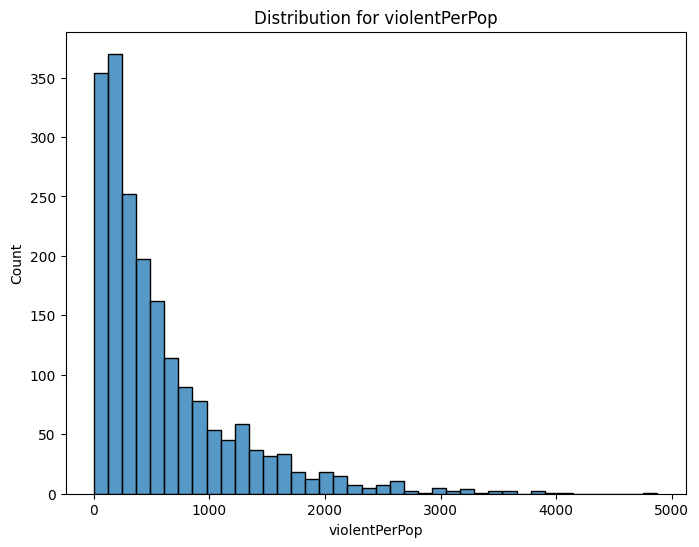

In [102]:
plt.figure(figsize=(8,6))
sns.histplot(data=f_df, x='violentPerPop', bins=40)
plt.title('Distribution for violentPerPop')

Checking and filling in missing values


<Axes: >

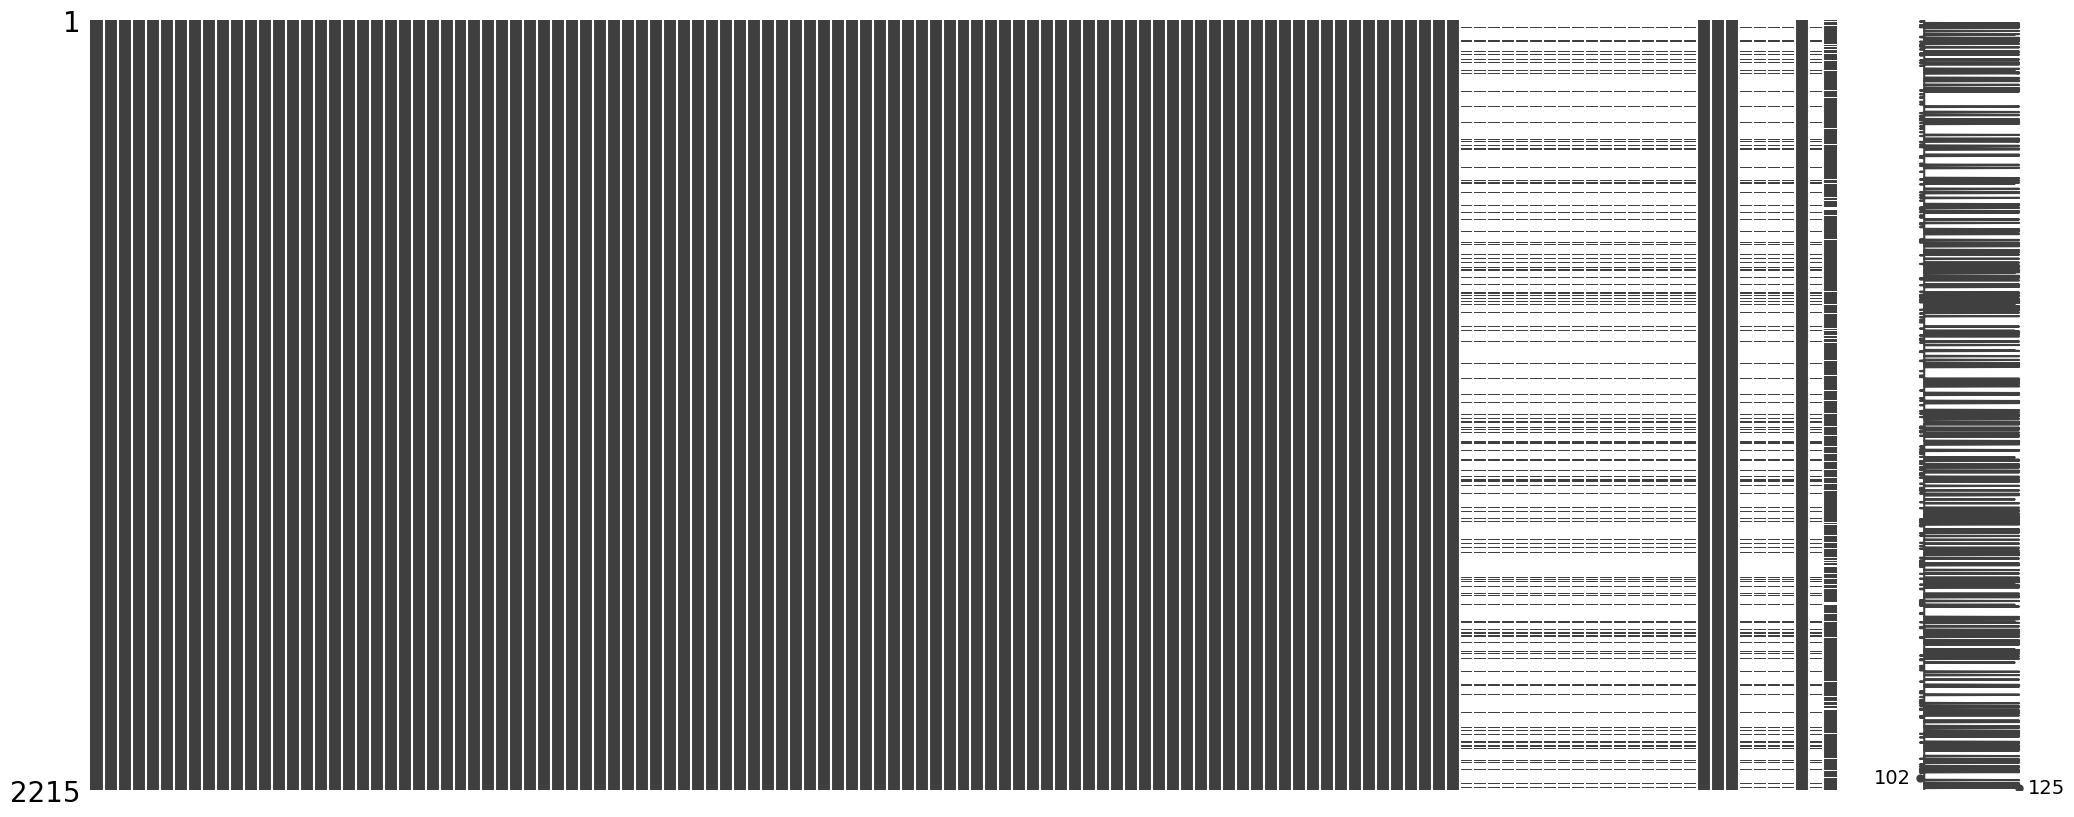

In [103]:
msno.matrix(f_df)

<Axes: >

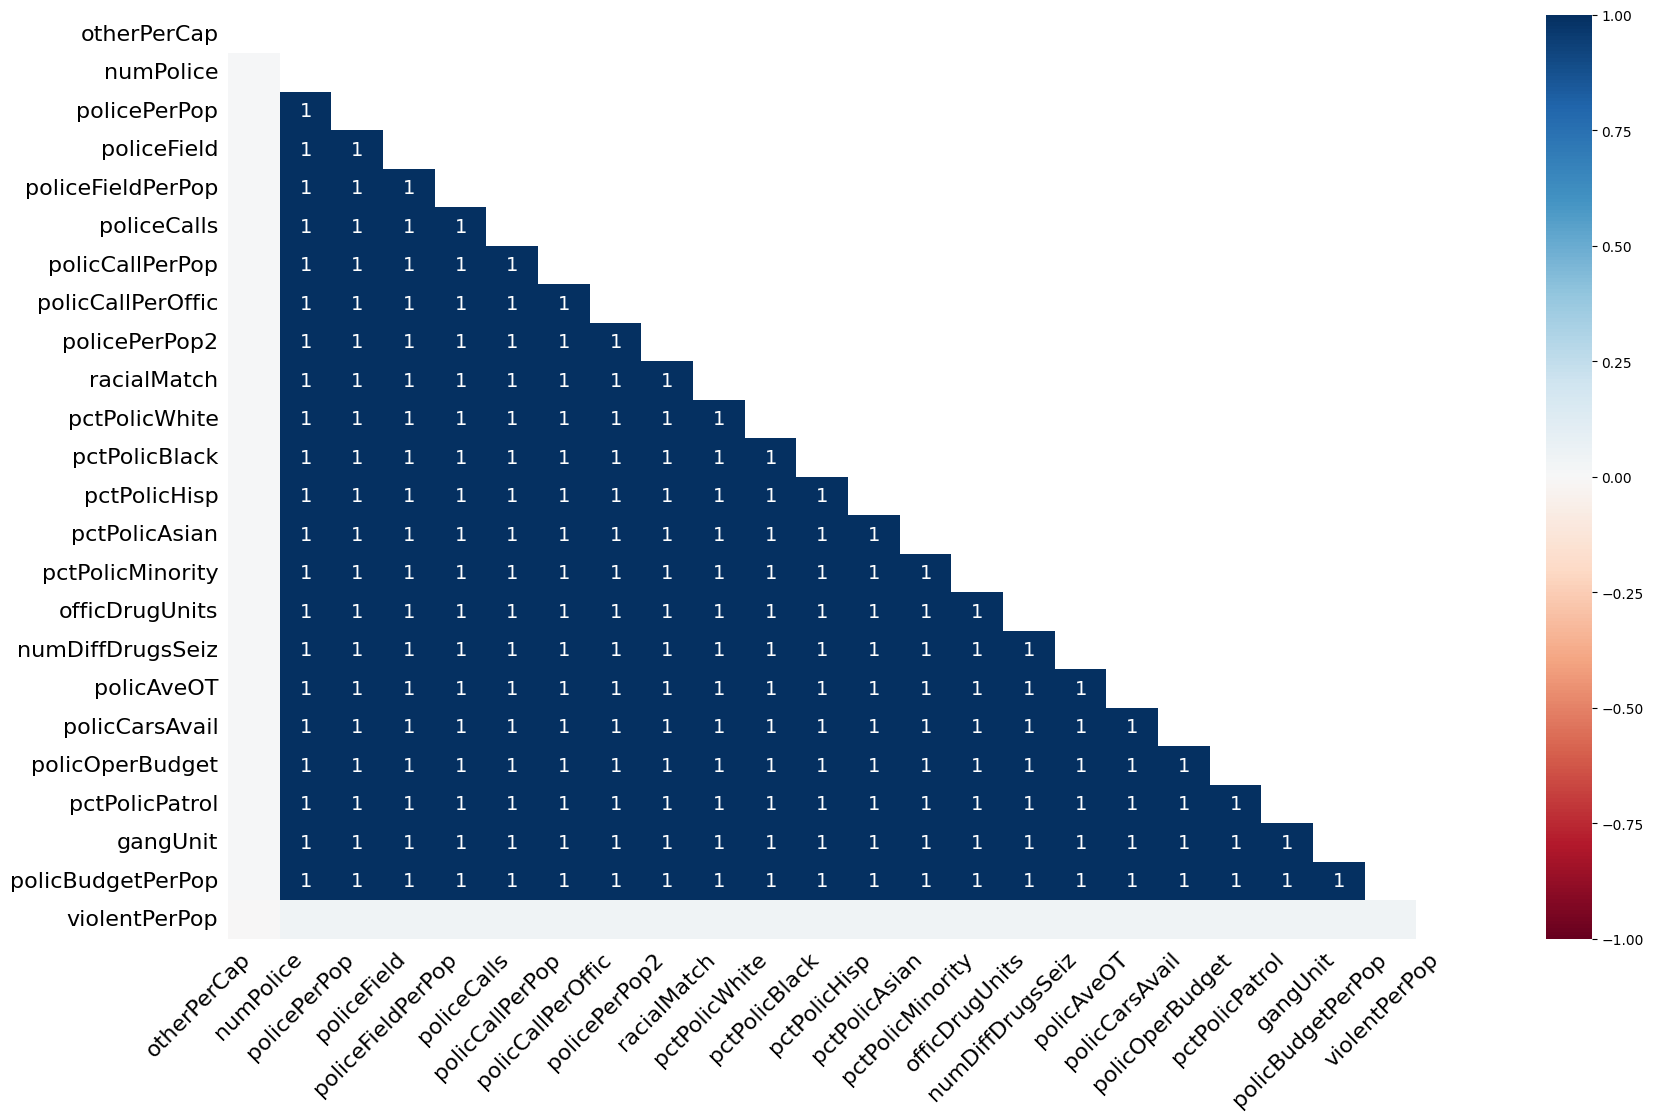

In [104]:
msno.heatmap(f_df)

<Axes: >

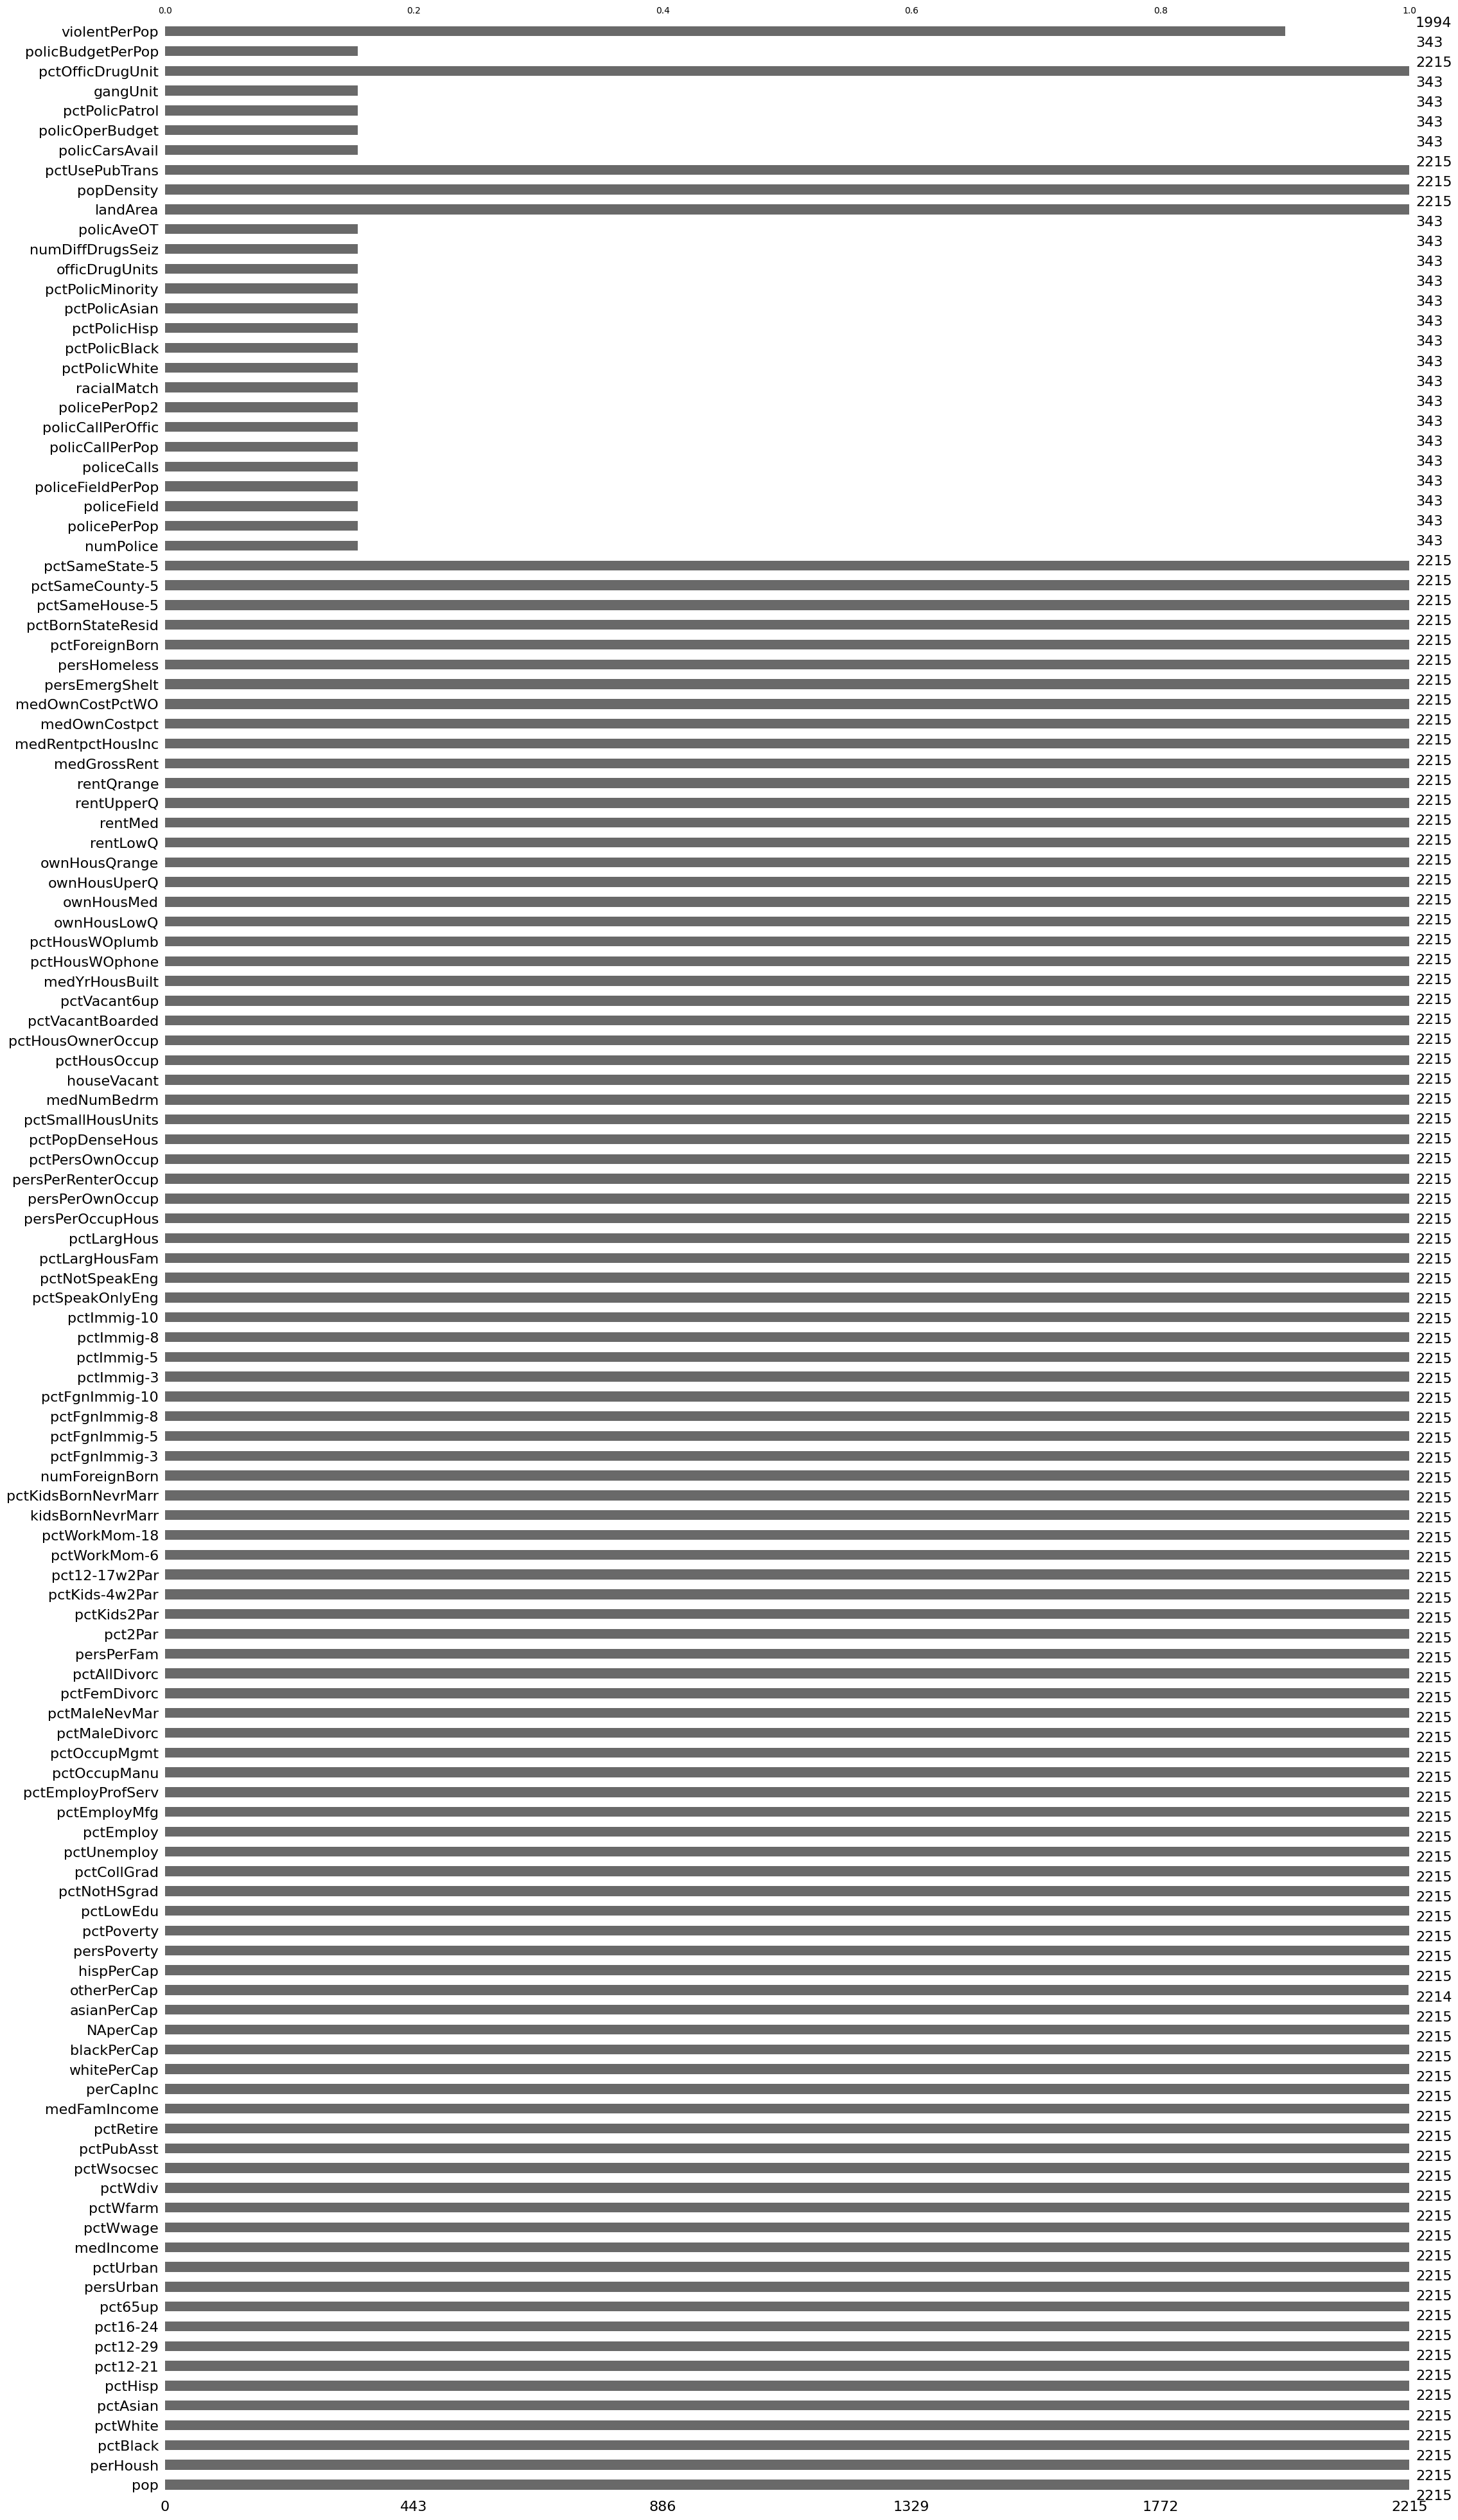

In [105]:
msno.bar(f_df)

Missing values are mainly related to the police and are located in several columns but in the same rows.


In [106]:
print(f_df.isna().sum()[f_df.isna().sum() > 0])

otherPerCap             1
numPolice            1872
policePerPop         1872
policeField          1872
policeFieldPerPop    1872
policeCalls          1872
policCallPerPop      1872
policCallPerOffic    1872
policePerPop2        1872
racialMatch          1872
pctPolicWhite        1872
pctPolicBlack        1872
pctPolicHisp         1872
pctPolicAsian        1872
pctPolicMinority     1872
officDrugUnits       1872
numDiffDrugsSeiz     1872
policAveOT           1872
policCarsAvail       1872
policOperBudget      1872
pctPolicPatrol       1872
gangUnit             1872
policBudgetPerPop    1872
violentPerPop         221
dtype: int64


Checking for Missing At Random (MAR).


In [107]:
f_df['numPoliceMissings'] = f_df['numPolice'].isna().astype(int)
display(f_df.corr()['numPoliceMissings'].sort_values(ascending=True).head(10),
        f_df.corr()['numPoliceMissings'].sort_values(ascending=False).head(10))

pctOfficDrugUnit      -0.80
violentPerPop         -0.37
pctKidsBornNevrMarr   -0.36
houseVacant           -0.36
persUrban             -0.32
pop                   -0.31
pctVacantBoarded      -0.29
persPoverty           -0.29
pctUrban              -0.28
pctFemDivorc          -0.27
Name: numPoliceMissings, dtype: float64

numPoliceMissings   1.00
pctKids2Par         0.33
pct12-17w2Par       0.33
pct2Par             0.32
pctHousOwnerOccup   0.31
pctWhite            0.30
pctPersOwnOccup     0.30
pctKids-4w2Par      0.28
medNumBedrm         0.24
pctSpeakOnlyEng     0.17
Name: numPoliceMissings, dtype: float64

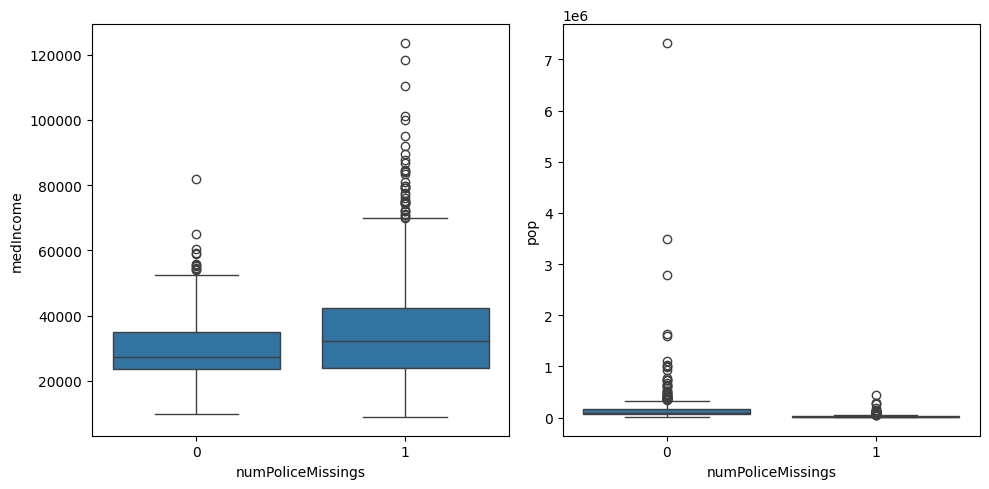

In [108]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax = ax.flatten()
sns.boxplot(data=f_df, x='numPoliceMissings', y='medIncome', ax = ax[0])
sns.boxplot(data=f_df, x='numPoliceMissings', y='pop', ax = ax[1])
plt.tight_layout()

Due to the presence of strong correlations and considering the graphs, it can be concluded that this is MAR. Next, models capable of handling missing values will be used, along with imputation using KNN.


Examining the data distribution



In [109]:
numerical_features = f_df.columns
n = len(numerical_features)
cols = 2
rows = (n + 1) // cols
fig, ax = plt.subplots(rows, cols, figsize = (20, 4 * rows))
ax = ax.flatten()
for i in range(n):
  sns.histplot(data=f_df, x=f_df[numerical_features[i]], bins=30, ax=ax[i])
for j in range(i+1, len(ax)):
  fig.delaxes(ax[j])
plt.tight_layout()

Examining the presence of outliers and their significance


In [110]:
fig, ax = plt.subplots(rows, cols, figsize=(20, 4 * rows))
ax = ax.flatten()
for i in range(n):
  sns.boxplot(data=f_df, y=numerical_features[i], ax=ax[i])


for j in range(i+1, len(ax)):
  fig.delaxes(ax[j])

plt.tight_layout()

In [111]:
f_df_clean = f_df.dropna(subset=['violentPerPop'])
numerical_features = f_df_clean.columns.tolist()
numerical_features.remove('violentPerPop')

for c in numerical_features:
  p75 = f_df_clean[f_df_clean[c] > 0][c].quantile(0.75)
  p25 = f_df_clean[f_df_clean[c] > 0][c].quantile(0.25)
  iqr = p75 - p25
  upper_limit = p75 + 1.5 * iqr
  lower_limit = p25 - 1.5 * iqr

  higher_outliers = f_df_clean[f_df_clean[c] > upper_limit]
  lower_outliers = f_df_clean[f_df_clean[c] < lower_limit]

  threshold_high = f_df_clean['violentPerPop'].quantile(0.75)
  threshold_low = f_df_clean['violentPerPop'].quantile(0.25)

  high_crime_outliers_high = higher_outliers[higher_outliers['violentPerPop'] > threshold_high]
  high_crime_outliers_low = lower_outliers[lower_outliers['violentPerPop'] > threshold_high]

  low_crime_outliers_high = higher_outliers[higher_outliers['violentPerPop'] < threshold_low]
  low_crime_outliers_low = lower_outliers[lower_outliers['violentPerPop'] < threshold_low]

  print(
      f"column: {c}, upper limit: {upper_limit:.2f}, number of high outliers: {len(higher_outliers)}, lower limit: {lower_limit:.2f}, number of low outliers: {len(lower_outliers)}, has high crime: {len(high_crime_outliers_high) + len(high_crime_outliers_low)}, has low crime: {len(low_crime_outliers_high) + len(low_crime_outliers_low)} \n"
  )


column: pop, upper limit: 86345.50, number of high outliers: 200, lower limit: -28832.50, number of low outliers: 0, has high crime: 129, has low crime: 3 

column: perHoush, upper limit: 3.39, number of high outliers: 80, lower limit: 1.95, number of low outliers: 7, has high crime: 36, has low crime: 18 

column: pctBlack, upper limit: 28.50, number of high outliers: 210, lower limit: -15.59, number of low outliers: 0, has high crime: 163, has low crime: 2 

column: pctWhite, upper limit: 126.15, number of high outliers: 0, lower limit: 45.72, number of low outliers: 78, has high crime: 65, has low crime: 0 

column: pctAsian, upper limit: 5.93, number of high outliers: 219, lower limit: -2.58, number of low outliers: 0, has high crime: 65, has low crime: 44 

column: pctHisp, upper limit: 20.14, number of high outliers: 237, lower limit: -10.62, number of low outliers: 0, has high crime: 126, has low crime: 2 

column: pct12-21, upper limit: 20.12, number of high outliers: 119, lowe

Many outliers are associated with high crime rates; for now, they will not be removed, and a model capable of handling them will be selected.


Checking for duplicates and assessing variability


In [112]:
duplicate_rows = f_df_clean[f_df_clean.duplicated()]
duplicate_rows

Empty DataFrame
Columns: [pop, perHoush, pctBlack, pctWhite, pctAsian, pctHisp, pct12-21, pct12-29, pct16-24, pct65up, persUrban, pctUrban, medIncome, pctWwage, pctWfarm, pctWdiv, pctWsocsec, pctPubAsst, pctRetire, medFamIncome, perCapInc, whitePerCap, blackPerCap, NAperCap, asianPerCap, otherPerCap, hispPerCap, persPoverty, pctPoverty, pctLowEdu, pctNotHSgrad, pctCollGrad, pctUnemploy, pctEmploy, pctEmployMfg, pctEmployProfServ, pctOccupManu, pctOccupMgmt, pctMaleDivorc, pctMaleNevMar, pctFemDivorc, pctAllDivorc, persPerFam, pct2Par, pctKids2Par, pctKids-4w2Par, pct12-17w2Par, pctWorkMom-6, pctWorkMom-18, kidsBornNevrMarr, pctKidsBornNevrMarr, numForeignBorn, pctFgnImmig-3, pctFgnImmig-5, pctFgnImmig-8, pctFgnImmig-10, pctImmig-3, pctImmig-5, pctImmig-8, pctImmig-10, pctSpeakOnlyEng, pctNotSpeakEng, pctLargHousFam, pctLargHous, persPerOccupHous, persPerOwnOccup, persPerRenterOccup, pctPersOwnOccup, pctPopDenseHous, pctSmallHousUnits, medNumBedrm, houseVacant, pctHousOccup, pctHousOwnerOccup, pctVacantBoarded, pctVacant6up, medYrHousBuilt, pctHousWOphone, pctHousWOplumb, ownHousLowQ, ownHousMed, ownHousUperQ, ownHousQrange, rentLowQ, rentMed, rentUpperQ, rentQrange, medGrossRent, medRentpctHousInc, medOwnCostpct, medOwnCostPctWO, persEmergShelt, persHomeless, pctForeignBorn, pctBornStateResid, pctSameHouse-5, pctSameCounty-5, pctSameState-5, numPolice, policePerPop, ...]
Index: []

In [113]:
f_df_clean.var().sort_values().head(30)

persPerFam             0.06
persPerOwnOccup        0.09
persPerOccupHous       0.11
perHoush               0.12
numPoliceMissings      0.13
persPerRenterOccup     0.16
pctHousWOplumb         0.19
medNumBedrm            0.27
pctWfarm               0.49
medOwnCostPctWO        2.11
pctImmig-3             2.71
pctPolicAsian          3.10
pctImmig-5             6.47
pctUnemploy            7.43
pctMaleDivorc          7.79
numDiffDrugsSeiz       8.09
pctOfficDrugUnit       8.49
medRentpctHousInc      8.55
medOwnCostpct          8.81
pctAllDivorc           8.93
pctKidsBornNevrMarr    9.45
pctFemDivorc          10.59
pctLargHous           10.92
pctImmig-8            11.55
pctVacantBoarded      11.87
pctLargHousFam        15.44
gangUnit              16.47
pctHousWOphone        16.97
pctNotSpeakEng        19.22
pctImmig-10           19.31
dtype: float64

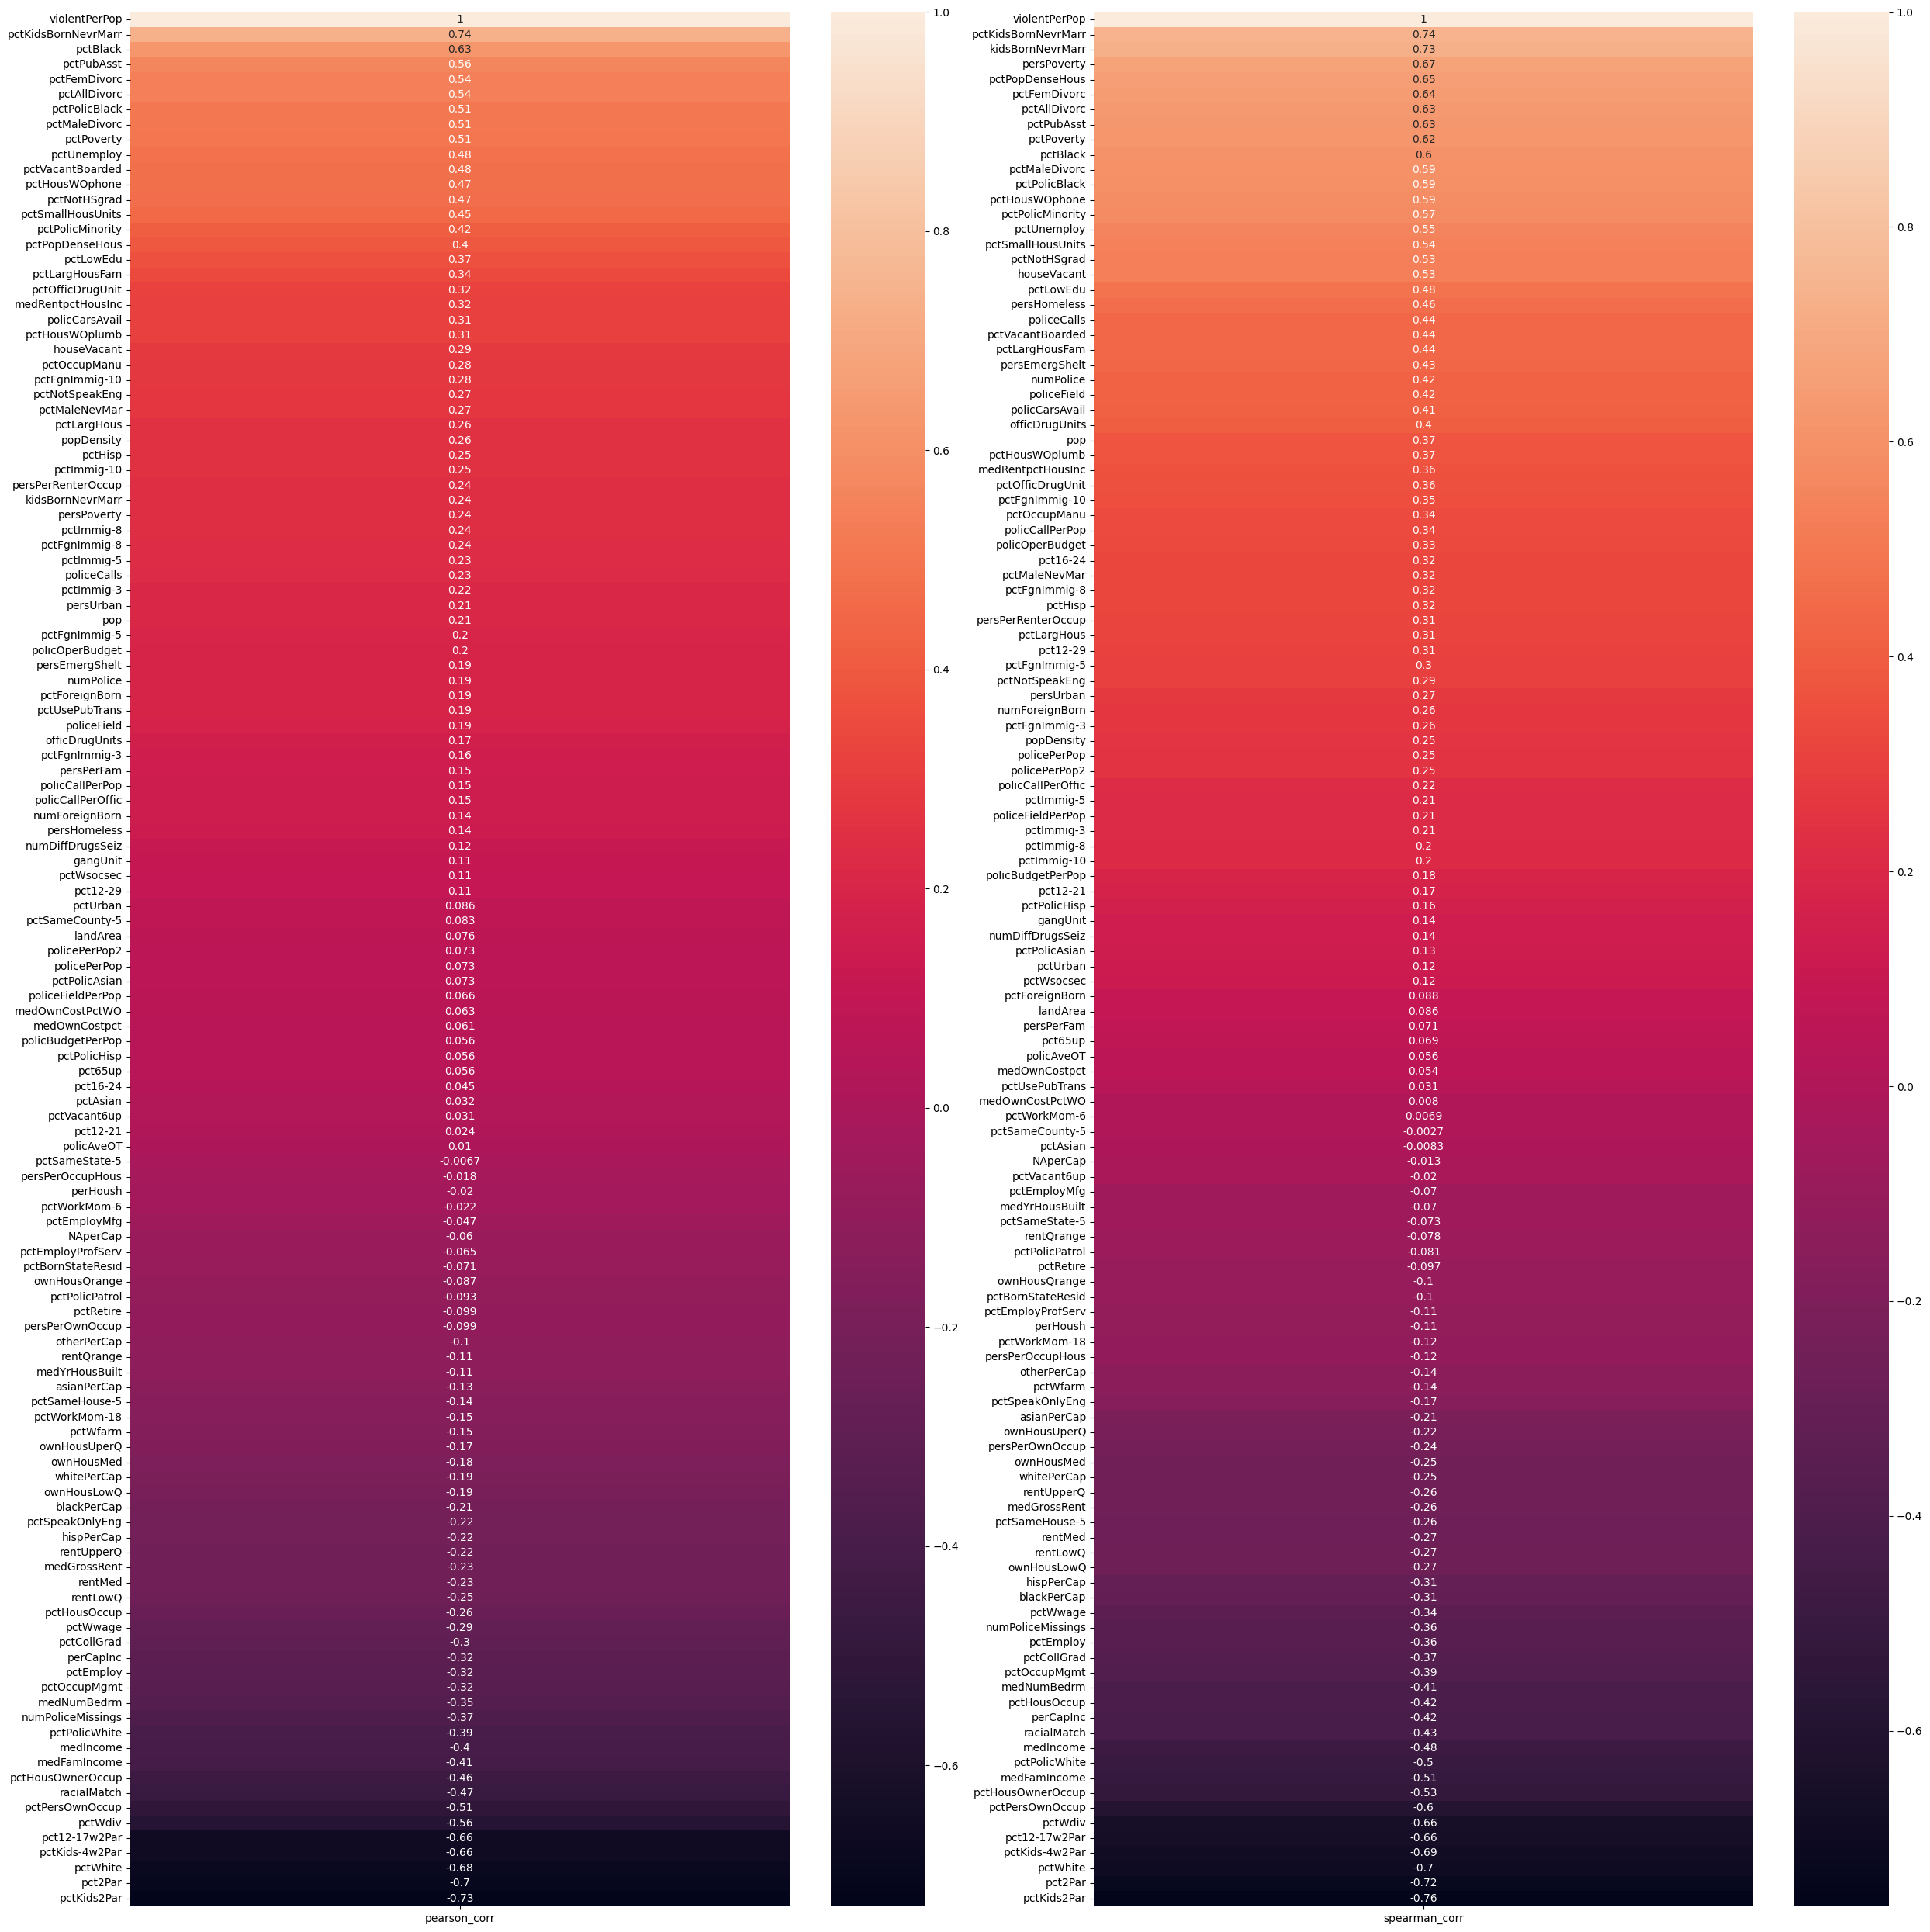

In [114]:
target_corr_pearson = f_df_clean.corr(method='pearson')['violentPerPop'].sort_values(ascending=False).to_frame(name='pearson_corr')
target_corr_spearman = f_df_clean.corr(method='spearman')['violentPerPop'].sort_values(ascending=False).to_frame(name='spearman_corr')
fig, ax = plt.subplots(1,2, figsize=(25,25))
ax = ax.flatten()
sns.heatmap(target_corr_pearson, ax = ax[0], annot=True)
sns.heatmap(target_corr_spearman, ax = ax[1], annot=True)
plt.tight_layout()

Trying to fill missing values with the median due to the skewed distribution, then reviewing the correlation again.


In [115]:
median_f_df = f_df_clean.fillna(f_df_clean.median())
miss_columns = median_f_df.columns[f_df_clean.isna().any()].to_list()
miss_columns_df = median_f_df[miss_columns].copy()
miss_columns_df['violentPerPop'] = f_df_clean['violentPerPop']
miss_columns_df

otherPerCap  numPolice  policePerPop  policeField  policeFieldPerPop  \
0         5115.00     173.00        196.01       152.00             170.16   
1         5250.00     173.00        196.01       152.00             170.16   
2         5954.00     173.00        196.01       152.00             170.16   
3         2451.00     173.00        196.01       152.00             170.16   
5         7192.00     173.00        196.01       152.00             170.16   
...           ...        ...           ...          ...                ...   
2210      6470.00     173.00        196.01       152.00             170.16   
2211     11471.00     173.00        196.01       152.00             170.16   
2212      8532.00     173.00        196.01       152.00             170.16   
2213      4436.00     173.00        196.01       152.00             170.16   
2214      7540.00     173.00        196.01       152.00             170.16   

      policeCalls  policCallPerPop  policCallPerOffic  policePerPop2  \
0        89205.00         91034.60             444.80         196.00   
1        89205.00         91034.60             444.80         196.00   
2        89205.00         91034.60             444.80         196.00   
3        89205.00         91034.60             444.80         196.00   
5        89205.00         91034.60             444.80         196.00   
...           ...              ...                ...            ...   
2210     89205.00         91034.60             444.80         196.00   
2211     89205.00         91034.60             444.80         196.00   
2212     89205.00         91034.60             444.80         196.00   
2213     89205.00         91034.60             444.80         196.00   
2214     89205.00         91034.60             444.80         196.00   

      racialMatch  pctPolicWhite  pctPolicBlack  pctPolicHisp  pctPolicAsian  \
0           87.95          86.18           4.84          2.11           0.00   
1           87.95          86.18           4.84          2.11           0.00   
2           87.95          86.18           4.84          2.11           0.00   
3           87.95          86.18           4.84          2.11           0.00   
5           87.95          86.18           4.84          2.11           0.00   
...           ...            ...            ...           ...            ...   
2210        87.95          86.18           4.84          2.11           0.00   
2211        87.95          86.18           4.84          2.11           0.00   
2212        87.95          86.18           4.84          2.11           0.00   
2213        87.95          86.18           4.84          2.11           0.00   
2214        87.95          86.18           4.84          2.11           0.00   

      pctPolicMinority  officDrugUnits  numDiffDrugsSeiz  policAveOT  \
0                11.39           12.00              9.00       99.00   
1                11.39           12.00              9.00       99.00   
2                11.39           12.00              9.00       99.00   
3                11.39           12.00              9.00       99.00   
5                11.39           12.00              9.00       99.00   
...                ...             ...               ...         ...   
2210             11.39           12.00              9.00       99.00   
2211             11.39           12.00              9.00       99.00   
2212             11.39           12.00              9.00       99.00   
2213             11.39           12.00              9.00       99.00   
2214             11.39           12.00              9.00       99.00   

      policCarsAvail  policOperBudget  pctPolicPatrol  gangUnit  \
0              86.00      10754972.00           89.44      5.00   
1              86.00      10754972.00           89.44      5.00   
2              86.00      10754972.00           89.44      5.00   
3              86.00      10754972.00           89.44      5.00   
5              86.00      10754972.00      

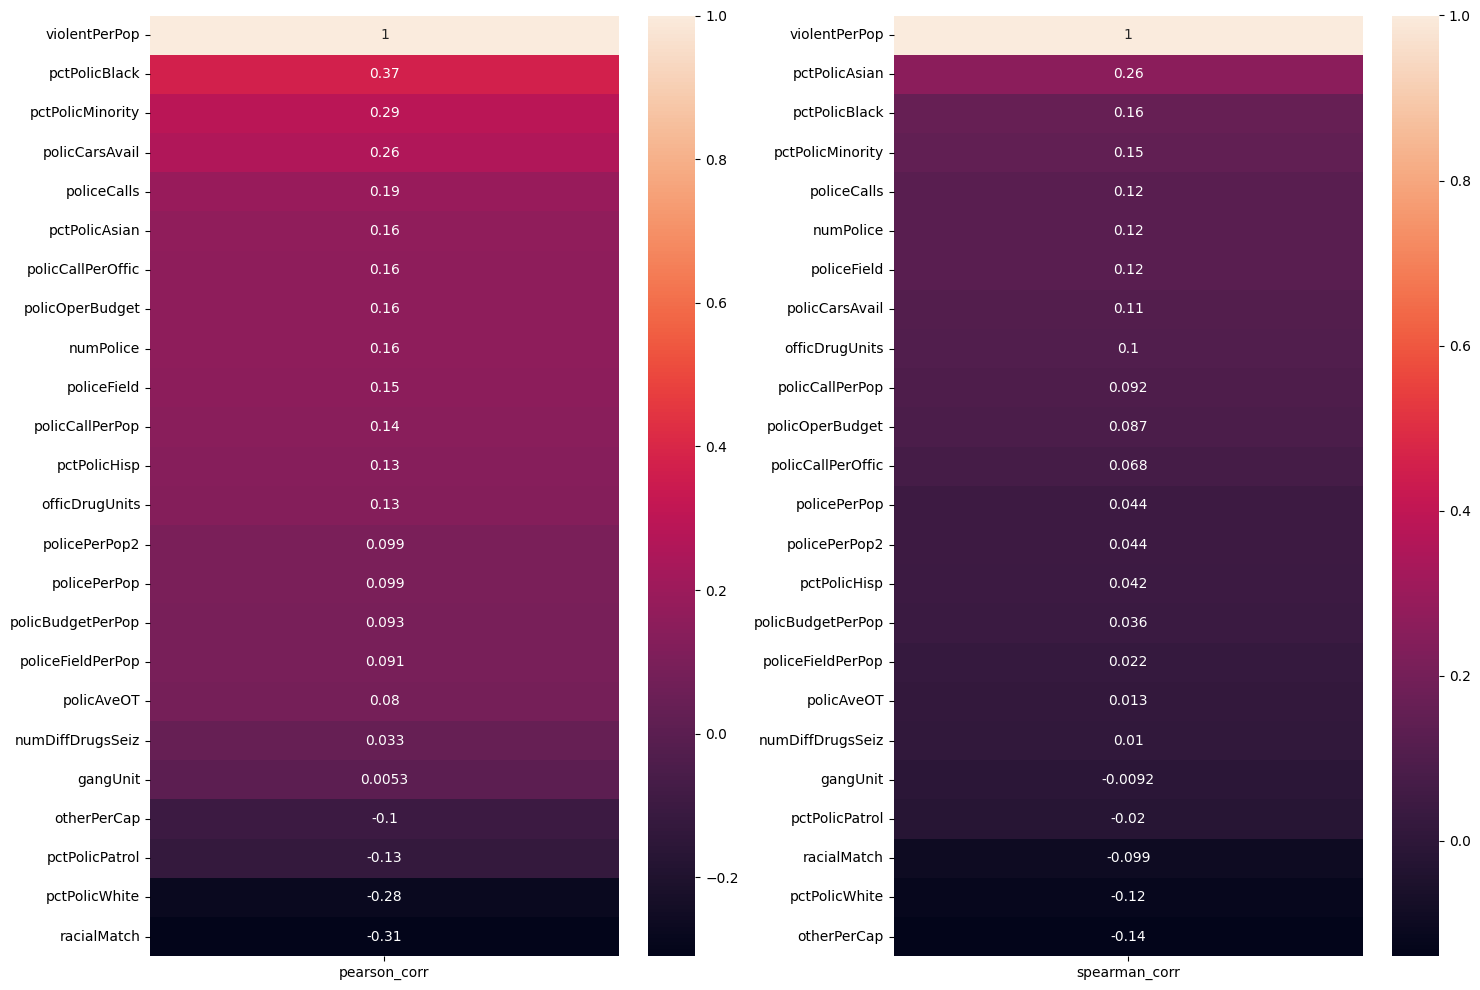

In [116]:
target_corr_pearson_miss = miss_columns_df.corr(method='pearson')['violentPerPop'].sort_values(ascending=False).to_frame(name='pearson_corr')
target_corr_spearman_miss = miss_columns_df.corr(method='spearman')['violentPerPop'].sort_values(ascending=False).to_frame(name='spearman_corr')
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax = ax.flatten()
sns.heatmap(target_corr_pearson_miss, ax = ax[0], annot=True)
sns.heatmap(target_corr_spearman_miss, ax = ax[1], annot=True)
plt.tight_layout()

After filling missing values with the median, the correlation worsened because there were many missing values. Therefore, this imputation method will not be applied for now.


Checking feature correlations and removing those with values above 90%


In [117]:
corr_matrix = f_df_clean.drop(columns='violentPerPop').corr().abs()
upper_mask = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
to_drop = [column for column in upper_mask.columns if any(upper_mask[column] > 0.9)]
to_drop

['pct16-24',
 'persUrban',
 'pctWsocsec',
 'medFamIncome',
 'perCapInc',
 'whitePerCap',
 'persPoverty',
 'pctNotHSgrad',
 'pctOccupMgmt',
 'pctFemDivorc',
 'pctAllDivorc',
 'pctKids2Par',
 'pctKids-4w2Par',
 'pct12-17w2Par',
 'kidsBornNevrMarr',
 'numForeignBorn',
 'pctFgnImmig-5',
 'pctFgnImmig-8',
 'pctFgnImmig-10',
 'pctImmig-5',
 'pctImmig-8',
 'pctImmig-10',
 'pctSpeakOnlyEng',
 'pctNotSpeakEng',
 'pctLargHous',
 'persPerOccupHous',
 'persPerOwnOccup',
 'houseVacant',
 'pctHousOwnerOccup',
 'ownHousMed',
 'ownHousUperQ',
 'rentMed',
 'rentUpperQ',
 'medGrossRent',
 'persEmergShelt',
 'persHomeless',
 'pctForeignBorn',
 'numPolice',
 'policeField',
 'policeFieldPerPop',
 'policeCalls',
 'policePerPop2',
 'pctPolicMinority',
 'officDrugUnits',
 'policOperBudget',
 'policBudgetPerPop']

There are many highly correlated features; they will be removed to reduce noise.


In [118]:
f_df_clean = f_df_clean.drop(columns=to_drop)

In [119]:
f_df_clean.shape

(1994, 80)

There are features with very low variability and correlation, but due to missing data that may be important for the final decision, features will also be evaluated using RandomForest.


Encoding the categorical feature GangUnit.


In [120]:
f_df['gangUnit'] = f_df['gangUnit'].fillna('Missing')
f_df = pd.get_dummies(data=f_df, columns=['gangUnit'], dtype=int)

### **Model Training**

In [121]:
def model_scoring(y_train, y_test, y_predict_train, y_predict_test):

  train_mae = mean_absolute_error(y_train, y_predict_train)
  test_mae = mean_absolute_error(y_test, y_predict_test)

  train_r2 = r2_score(y_train, y_predict_train)
  test_r2 = r2_score(y_test, y_predict_test)

  train_mse = mean_squared_error(y_train, y_predict_train)
  test_mse = mean_squared_error(y_test, y_predict_test)

  train_rmse = root_mean_squared_error(y_train, y_predict_train)
  test_rmse = root_mean_squared_error(y_test, y_predict_test)

  print(
      f'''Regression metrics:
      MAE score: train - {train_mae:.4f}, test - {test_mae:.4f}
      R2 score: train - {train_r2:.4f}, test - {test_r2:.4f}
      MSE score:  train - {train_mse:.4f}, test - {test_mse:.4f}
      RMSE score: train - {train_rmse:.4f}, test - {test_rmse:.4f}'''
  )

In [122]:
def inmodel_score(model, if_ppl):
  display(model.best_params_, model.best_score_)
  x_columns = X_train.columns
  if if_ppl:
    display(pd.DataFrame(zip(x_columns, model.best_estimator_.named_steps['model'].feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).style.background_gradient())
  else:
    display(pd.DataFrame(zip(x_columns, model.best_estimator_.feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).style.background_gradient())

In [123]:
def inmodel_feature_importance(model, if_ppl):
  x_columns = X_train.columns
  if if_ppl:
    display(pd.DataFrame(zip(x_columns, model.named_steps['model'].feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).style.background_gradient())
  else:
    display(pd.DataFrame(zip(x_columns, model.feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).style.background_gradient())

In [124]:
rnd_state = 37
def train_test(df, rndm_state):
  X = df.drop('violentPerPop', axis=1)
  y = df['violentPerPop']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rndm_state)
  print(X_train.shape, X_test.shape)
  return X_train, X_test, y_train, y_test

In [125]:
X_train, X_test, y_train, y_test = train_test(f_df_clean, rnd_state)

(1595, 79) (399, 79)


In [126]:
rf = RandomForestRegressor(random_state=rnd_state)
param_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_depth': [None, 1, 5, 10, 20],
    'max_leaf_nodes':[4, 8, 16, 32]
}
rf_rs = RandomizedSearchCV(estimator=rf, param_distributions=param_rf, cv=10, n_jobs=-1 )
rf_rs.fit(X_train, y_train)

display(rf_rs.best_params_, rf_rs.best_score_)

y_pred_train = rf_rs.predict(X_train)
y_pred_test = rf_rs.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)

{'n_estimators': 10, 'max_leaf_nodes': 32, 'max_depth': 20}

np.float64(0.5864394262318877)

Regression metrics:
      MAE score: train - 195.7614, test - 239.0275
      R2 score: train - 0.8035, test - 0.6392
      MSE score:  train - 75338.9005, test - 127913.4759
      RMSE score: train - 274.4793, test - 357.6499


Trying to select the best hyperparameters.


In [127]:
rf = RandomForestRegressor(random_state=rnd_state)
param_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_depth': [1, 5, 7, 10],
    'min_samples_leaf':[4, 8, 12, 16, 22, 32],
    'max_features': [1, 3, 5, 8]
}
rf_rs = RandomizedSearchCV(estimator=rf, param_distributions=param_rf, cv=10, n_jobs=-1, n_iter=15 )
rf_rs.fit(X_train, y_train)
y_pred_train = rf_rs.predict(X_train)
y_pred_test = rf_rs.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
inmodel_score(rf_rs, False)

Regression metrics:
      MAE score: train - 181.0593, test - 237.3235
      R2 score: train - 0.7988, test - 0.6222
      MSE score:  train - 77151.0901, test - 133932.2046
      RMSE score: train - 277.7609, test - 365.9675


{'n_estimators': 100,
 'min_samples_leaf': 4,
 'max_features': 3,
 'max_depth': 10}

np.float64(0.6057602357484873)

Evaluating overfitting.


In [128]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estim, X, y, cv=5, scoring='neg_mean_squared_error'):
  train_sizes, train_scores, valid_scores=learning_curve(estimator=estim, X=X, y=y,
                                                         cv=cv, scoring=scoring, n_jobs=-1,
                                                         shuffle=True, random_state=rnd_state)

  train_scores_mean = -train_scores.mean(axis=1)
  train_scores_std = train_scores.std(axis=1)
  valid_scores_mean = -valid_scores.mean(axis=1)
  valid_scores_std = valid_scores.std(axis=1)

  plt.figure(figsize=(6,6))

  sns.lineplot(x=train_sizes, y=train_scores_mean, label='Train MSE', color='blue')
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')

  sns.lineplot(x=train_sizes, y=valid_scores_mean, label='Valid MSE', color='green')
  plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color='green')

  plt.title('Learning Curve')
  plt.xlabel('Training Set Size')
  plt.ylabel('Mean Squared Error (MSE)')
  plt.legend(loc='best')
  plt.tight_layout()

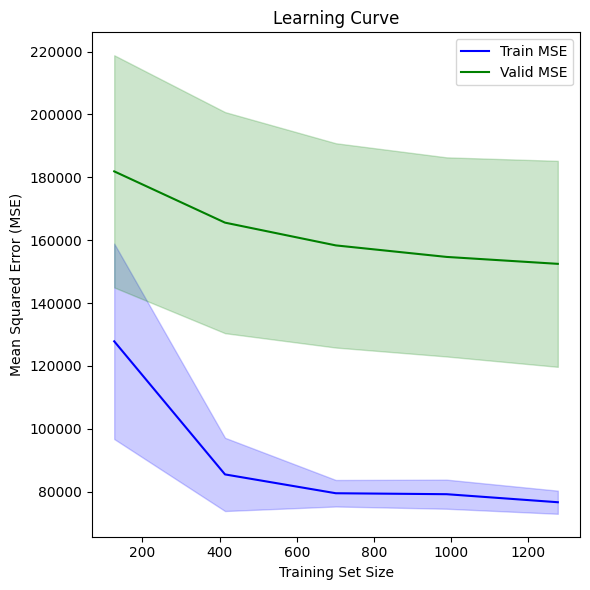

In [129]:
plot_learning_curve(rf_rs.best_estimator_, X_train, y_train)

A large difference in training is observed. The model will be further simplified.


In [130]:
rf = RandomForestRegressor(
    random_state=rnd_state,
    n_jobs=-1,
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=26,
    max_features=15
    )

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
inmodel_feature_importance(rf, False)


Regression metrics:
      MAE score: train - 225.8168, test - 236.5511
      R2 score: train - 0.6817, test - 0.6210
      MSE score:  train - 122057.4172, test - 134352.5951
      RMSE score: train - 349.3672, test - 366.5414


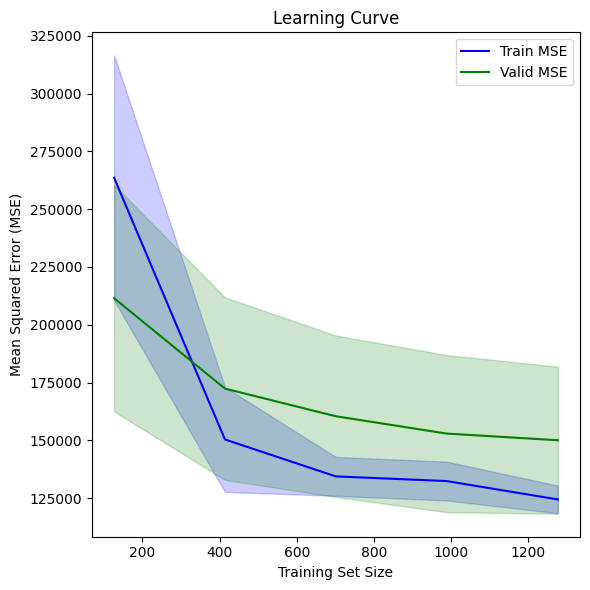

In [131]:
plot_learning_curve(rf, X_train, y_train)

This model shows clearly less overfitting and a decent result. It will be kept as the baseline.


In [45]:
best_model_rdf = rf_rs.best_estimator_
best_params_rdf = {'n_estimators': 300, 'min_samples_leaf': 26, 'max_features': 15, 'max_depth': 6}
x_columns = X_train.columns
features_best_params_rdf = pd.DataFrame(zip(x_columns, rf_rs.best_estimator_.feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
features_best_params_rdf

Feature  Importance
35  pctKidsBornNevrMarr        0.13
2              pctBlack        0.10
3              pctWhite        0.09
32              pct2Par        0.07
13              pctWdiv        0.05
..                  ...         ...
56      medOwnCostPctWO        0.00
9              pctUrban        0.00
17             NAperCap        0.00
77     pctOfficDrugUnit        0.00
43          medNumBedrm        0.00

[79 rows x 2 columns]

Trying to fill missing values using KNNImputer.


In [46]:
pipeline_knn_rfr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),
    ('model', RandomForestRegressor(random_state=rnd_state, n_estimators= 300, min_samples_leaf= 26, max_features= 15, max_depth= 6, n_jobs=-1))
])

pipeline_knn_rfr.fit(X_train, y_train)
y_train_pred_knn_rfr = pipeline_knn_rfr.predict(X_train)
y_test_pred_knn_rfr = pipeline_knn_rfr.predict(X_test)
model_scoring(y_train, y_test, y_train_pred_knn_rfr, y_test_pred_knn_rfr)
inmodel_feature_importance(pipeline_knn_rfr, True)

Regression metrics:
      MAE score: train - 223.0197, test - 237.8932
      R2 score: train - 0.6887, test - 0.6187
      MSE score:  train - 119374.4772, test - 135180.1751
      RMSE score: train - 345.5061, test - 367.6686


In [47]:
def cross_v(model, X_train, y_train):
  n = 10
  cv = KFold(n_splits=n, shuffle=True, random_state=rnd_state)
  cv_scores = cross_val_score(
      model,
      X_train,
      y_train,
      cv=cv,
      scoring='r2',
      n_jobs=-1
  )

  print(f"CV scores: {cv_scores}")
  print(f"Mean R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

In [48]:
cross_v(pipeline_knn_rfr, X_train, y_train)

CV scores: [0.61757031 0.62798381 0.57632751 0.62580241 0.54744067 0.5844222
 0.62568457 0.69908928 0.62797646 0.63028408]
Mean R²: 0.6163 ± 0.0385


After KNN, no significant changes were observed; IterativeImputer will be tried.


In [49]:
pipeline_ii_rfr = Pipeline([
    ('imputer', IterativeImputer(random_state=rnd_state, max_iter=15, tol=1e-3)),
    ('model', RandomForestRegressor(random_state=rnd_state, n_estimators= 300, min_samples_leaf= 26, max_features= 15, max_depth= 6, n_jobs=-1))
])


pipeline_ii_rfr.fit(X_train, y_train)
y_train_pred_ii_rfr_rs = pipeline_ii_rfr.predict(X_train)
y_test_pred_ii_rfr_rs = pipeline_ii_rfr.predict(X_test)
model_scoring(y_train, y_test, y_train_pred_ii_rfr_rs, y_test_pred_ii_rfr_rs)
inmodel_feature_importance(pipeline_ii_rfr, True)

Regression metrics:
      MAE score: train - 224.6170, test - 239.0716
      R2 score: train - 0.6839, test - 0.6150
      MSE score:  train - 121202.0554, test - 136513.6532
      RMSE score: train - 348.1409, test - 369.4775


In [50]:
cross_v(pipeline_ii_rfr, X_train, y_train)

CV scores: [0.61408528 0.62388389 0.59359201 0.60332729 0.5370445  0.5686957
 0.62143038 0.68454852 0.61927472 0.63309242]
Mean R²: 0.6099 ± 0.0372


No significant results were obtained either. Features with missing values will be removed, keeping only the flag.


In [51]:
df_flaged = f_df_clean.copy()
for col in f_df_clean.columns:
  if df_flaged[col].isna().sum() > 2:
    df_flaged = df_flaged.drop(columns=col)

print(df_flaged.isna().sum()[df_flaged.isna().sum() > 0])

otherPerCap    1
dtype: int64


In [52]:
X_train, X_test, y_train, y_test = train_test(df_flaged, rnd_state)

(1595, 66) (399, 66)


In [53]:
rf = RandomForestRegressor(random_state=rnd_state, n_estimators= 300, min_samples_leaf= 26, max_features= 15, max_depth= 6, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
inmodel_feature_importance(rf, False)

Regression metrics:
      MAE score: train - 223.6872, test - 238.6225
      R2 score: train - 0.6862, test - 0.6185
      MSE score:  train - 120319.1994, test - 135240.2835
      RMSE score: train - 346.8706, test - 367.7503


In [54]:
cross_v(rf, X_train, y_train)

CV scores: [0.61644607 0.61395838 0.5862374  0.60392643 0.54275406 0.5762655
 0.62990601 0.69849596 0.62060742 0.64013526]
Mean R²: 0.6129 ± 0.0394


This also did not significantly affect the results. Features will be selected based on Spearman correlation where it is >0.33 or <−0.33.


In [55]:
target_coll = target_corr_spearman[target_corr_spearman['spearman_corr'].abs() > 0.33].index
target_coll_valid = [col for col in target_coll if col in f_df_clean.columns]
target_df = f_df_clean[target_coll_valid]

X_train, X_test, y_train, y_test = train_test(target_df, rnd_state)

(1595, 33) (399, 33)


In [56]:
rf = RandomForestRegressor(random_state=rnd_state, n_estimators= 300, min_samples_leaf= 26, max_features= 15, max_depth= 6, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
inmodel_feature_importance(rf, False)

Regression metrics:
      MAE score: train - 224.0762, test - 236.2430
      R2 score: train - 0.6838, test - 0.6229
      MSE score:  train - 121232.5934, test - 133681.8233
      RMSE score: train - 348.1847, test - 365.6252


In [57]:
cross_v(rf, X_train, y_train)

CV scores: [0.63050265 0.61238664 0.58273722 0.60880902 0.54069704 0.57370817
 0.62078914 0.69951645 0.61701866 0.64095489]
Mean R²: 0.6127 ± 0.0404


After changing the number of parameters, the result remained almost the same, but the number of parameters was significantly reduced.


Visually evaluating the model.


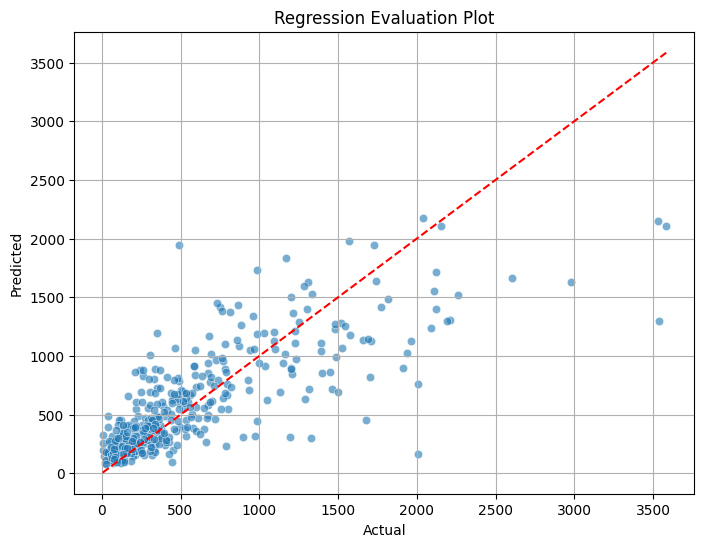

In [58]:
def plot_regression_results(y_true, y_pred):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # лінія y=x
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Regression Evaluation Plot')
    plt.grid(True)
    plt.show()

plot_regression_results(y_test, y_pred_test)

It is observed that the model performs best with the most common data, while predictions for high crime rates yield less accurate results.


Evaluating feature impact on the model using SHAP.


 97%|=================== | 1939/1994 [00:38<00:01]       

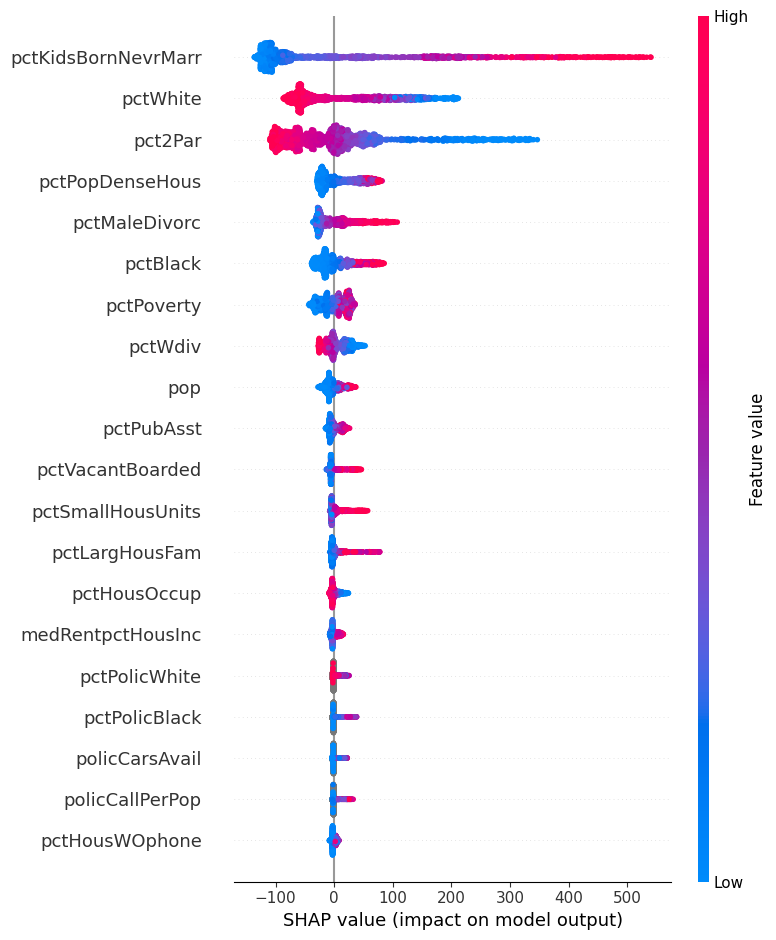

In [59]:
X_new = pd.concat([X_test, X_train])
explainer = shap.Explainer(rf, X_new)

shap_values = explainer(X_new)

shap.summary_plot(shap_values, X_new)

The SHAP analysis results are somewhat unexpected. The highest impact is from variables such as pctKidsBornNevrMarr and pct2Par, whereas it was expected that pop, pctPoverty, pctWhite, and pctBlack would be most influential. Although pctWhite remains quite significant, this indicates the importance of the social context when predicting the target variable.


Selecting features with feature importance above 0.005 from the baseline model.


In [60]:
best_featurs = features_best_params_rdf[features_best_params_rdf['Importance'] > 0.005]
best_featurs_valid = [col for col in best_featurs['Feature'] if col in f_df_clean.columns]
best_f_df = f_df_clean[best_featurs_valid].copy()
best_f_df['violentPerPop'] = f_df_clean['violentPerPop']
X_train, X_test, y_train, y_test = train_test(best_f_df, rnd_state)

(1595, 37) (399, 37)


In [61]:
rf = RandomForestRegressor(random_state=rnd_state,n_estimators= 300, min_samples_leaf= 26, max_features= 15, max_depth= 6, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
inmodel_feature_importance(rf, False)

Regression metrics:
      MAE score: train - 223.6327, test - 234.6840
      R2 score: train - 0.6861, test - 0.6249
      MSE score:  train - 120362.6845, test - 132979.2405
      RMSE score: train - 346.9333, test - 364.6632


In [62]:
cross_v(rf, X_train, y_train)

CV scores: [0.62755809 0.60908348 0.57429552 0.61111983 0.54467126 0.57473521
 0.62559259 0.70603654 0.61679864 0.63504546]
Mean R²: 0.6125 ± 0.0414


The result also did not change much, although the number of features was significantly reduced.


Visually evaluating the model.


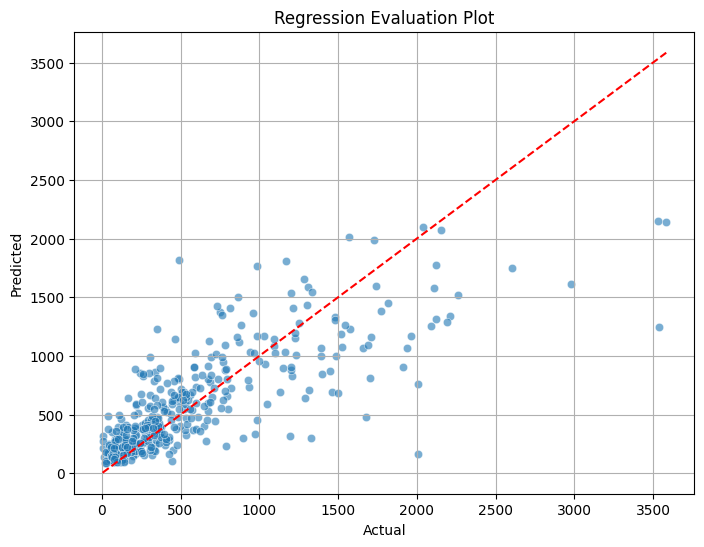

In [63]:
plot_regression_results(y_test, y_pred_test)

### **XGBRegressor**


Filling missing values with a marker number and trying to select the best hyperparameters.


In [64]:
f_df_marked = f_df_clean.fillna(-999)

In [65]:
X_train, X_test, y_train, y_test = train_test(f_df_marked, rnd_state)

(1595, 79) (399, 79)


In [66]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, missing=-999)

param_grid = {
    'seed': 100,
    'max_depth': 4,
    'min_child_weight': 1,
    'objective': 'reg:absoluteerror',
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,

}

cv_result = xgb.cv(
    params= param_grid,
    dtrain=dtrain,
    num_boost_round = 1000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds = 50,
    seed = 100,
    verbose_eval = 50

)

n_steps = cv_result.shape[0]
n_steps

[0]	train-rmse:628.60256+9.03873	test-rmse:628.25135+53.10427
[50]	train-rmse:322.13404+10.48954	test-rmse:391.31212+43.11966
[100]	train-rmse:291.80751+9.20805	test-rmse:385.80859+41.74471
[150]	train-rmse:271.89409+10.67842	test-rmse:382.60314+40.25330
[200]	train-rmse:255.87480+11.43444	test-rmse:379.42910+39.97613
[250]	train-rmse:244.34966+13.42723	test-rmse:378.56240+39.56864
[283]	train-rmse:239.36546+12.89913	test-rmse:378.65082+38.88991


235

In [67]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 0.8],
    'gamma': [0.1],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error",

)

xgb_search.fit(X_train, y_train)

y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
best_model = xgb_search.best_estimator_
importances = best_model.feature_importances_
print(f'Best score: {xgb_search.best_score_}')
pd.DataFrame(zip(X_train.columns, importances), columns=['Feature', 'Importance']) \
  .sort_values(by='Importance', ascending=False).style.background_gradient()

Regression metrics:
      MAE score: train - 93.7546, test - 217.9089
      R2 score: train - 0.8811, test - 0.6322
      MSE score:  train - 45595.0183, test - 130390.4824
      RMSE score: train - 213.5299, test - 361.0962
Best params: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score: -143296.82231952174


In [68]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [4,5,6],
    'min_child_weight': [4,5,6,8,10],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 0.8],
    'gamma': [0.1],


}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)

y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
best_model = xgb_search.best_estimator_
importances = best_model.feature_importances_
print(f'Best score: {xgb_search.best_score_}')
pd.DataFrame(zip(X_train.columns, importances), columns=['Feature', 'Importance']) \
  .sort_values(by='Importance', ascending=False).style.background_gradient()

Regression metrics:
      MAE score: train - 79.2075, test - 217.8724
      R2 score: train - 0.8987, test - 0.6435
      MSE score:  train - 38845.2268, test - 126380.0806
      RMSE score: train - 197.0919, test - 355.4998
Best params: {'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score: -142973.46898269345


In [69]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 0.8],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)
y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
print(f'Best score: {xgb_search.best_score_}')
best_model = xgb_search.best_estimator_


Regression metrics:
      MAE score: train - 104.5959, test - 214.3247
      R2 score: train - 0.8492, test - 0.6479
      MSE score:  train - 57826.7026, test - 124840.5086
      RMSE score: train - 240.4718, test - 353.3278
Best params: {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score: -140937.60303012852


In [70]:
param_grid = {
    'max_depth': 5,
    'min_child_weight': 5,
    'gamma': 0.1,
    'objective': 'reg:absoluteerror',
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,

}

cv_result = xgb.cv(
    params= param_grid,
    dtrain=dtrain,
    num_boost_round = 1000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds = 50,
    seed = 100,
    verbose_eval = 50

)

n_steps = cv_result.shape[0]
n_steps

[0]	train-rmse:629.02487+9.41805	test-rmse:628.51884+52.66140
[50]	train-rmse:307.07358+9.78698	test-rmse:393.66154+44.39545
[100]	train-rmse:272.88812+8.93611	test-rmse:387.35482+43.49420
[150]	train-rmse:252.34130+9.26385	test-rmse:384.51803+44.12570
[200]	train-rmse:239.03384+11.50194	test-rmse:384.85341+43.95391
[226]	train-rmse:234.33165+11.81925	test-rmse:384.97526+43.59466


177

In [71]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'learning_rate': [0.1],


}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)
y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
print(f'Best score: {xgb_search.best_score_}')
best_model = xgb_search.best_estimator_

Regression metrics:
      MAE score: train - 120.9824, test - 217.9940
      R2 score: train - 0.8242, test - 0.6366
      MSE score:  train - 67419.7552, test - 128843.4220
      RMSE score: train - 259.6531, test - 358.9477
Best params: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best score: -141098.4288178325


In [72]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.5, 0.55, 0.6, 0.65, 0.7],
    'colsample_bytree': [0.5, 0.55, 0.6, 0.65, 0.7],
    'learning_rate': [0.1],

}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)
y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
print(f'Best score: {xgb_search.best_score_}')
best_model = xgb_search.best_estimator_

Regression metrics:
      MAE score: train - 117.1224, test - 219.7571
      R2 score: train - 0.8340, test - 0.6343
      MSE score:  train - 63644.9219, test - 129642.6263
      RMSE score: train - 252.2795, test - 360.0592
Best params: {'subsample': 0.65, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best score: -139363.53905681995


In [73]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.65],
    'colsample_bytree': [0.6],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100],
    'learning_rate': [0.1],

}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)
y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
print(f'Best score: {xgb_search.best_score_}')
best_model = xgb_search.best_estimator_

Regression metrics:
      MAE score: train - 121.4959, test - 216.5760
      R2 score: train - 0.8323, test - 0.6345
      MSE score:  train - 64310.4586, test - 129582.7787
      RMSE score: train - 253.5951, test - 359.9761
Best params: {'subsample': 0.65, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best score: -139846.3256618923


In [74]:
xgb_reg = XGBRegressor(random_state=rnd_state, objective='reg:absoluteerror', n_estimators=n_steps, missing=-999, seed= 100)

param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0.1],
    'subsample': [0.65],
    'colsample_bytree': [0.6],
    'reg_alpha': [0.001, 0.005, 0.01, 0.05],
    'reg_lambda': [0.001, 0.005, 0.01, 0.05],
    'learning_rate': [0.1],

}

xgb_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    random_state=rnd_state,
    scoring = "neg_mean_squared_error"
)

xgb_search.fit(X_train, y_train)
y_pred_train = xgb_search.predict(X_train)
y_pred_test = xgb_search.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
print("Best params:", xgb_search.best_params_)
print(f'Best score: {xgb_search.best_score_}')
best_model = xgb_search.best_estimator_

Regression metrics:
      MAE score: train - 121.4959, test - 216.5760
      R2 score: train - 0.8323, test - 0.6345
      MSE score:  train - 64310.4586, test - 129582.7787
      RMSE score: train - 253.5951, test - 359.9761
Best params: {'subsample': 0.65, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best score: -139846.3256618923


In [75]:
param_grid = {
    'max_depth': 5,
    'min_child_weight': 5,
    'gamma': 0.1,
    'subsample': 0.65,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'learning_rate': 0.04,

}

cv_result = xgb.cv(
    params= param_grid,
    dtrain=dtrain,
    num_boost_round = 1000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds = 50,
    seed = 100,
    verbose_eval = 50

)

n_steps = cv_result.shape[0]
n_steps

[0]	train-rmse:602.94352+9.70094	test-rmse:604.67377+40.14275
[50]	train-rmse:263.93874+7.53694	test-rmse:378.96108+41.80233
[100]	train-rmse:200.79693+6.89880	test-rmse:369.31355+45.78748
[150]	train-rmse:165.52512+5.69657	test-rmse:368.67688+47.36765
[200]	train-rmse:139.14234+6.26397	test-rmse:368.62164+47.99117
[214]	train-rmse:132.50629+5.90108	test-rmse:368.66894+48.14744


165

In [76]:
xgb_reg = XGBRegressor(
    random_state=rnd_state,
    objective='reg:absoluteerror',
    n_estimators=n_steps,
    missing=-999,
    seed= 100,
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.65,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    reg_lambda=0.01,
    learning_rate=0.04,
    )


xgb_reg.fit(X_train, y_train)
y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
best_model = xgb_reg

Regression metrics:
      MAE score: train - 152.1511, test - 211.7336
      R2 score: train - 0.7643, test - 0.6482
      MSE score:  train - 90367.9359, test - 124727.0927
      RMSE score: train - 300.6126, test - 353.1672


The best hyperparameters were selected, yielding a stable result. These parameters are saved.


Selecting features based on Spearman correlation.


In [77]:
target_coll = target_corr_spearman[target_corr_spearman['spearman_corr'].abs() > 0.4].index
target_coll_valid = [col for col in target_coll if col in f_df_marked.columns]
target_df = f_df_marked[target_coll_valid]

X_train, X_test, y_train, y_test = train_test(target_df, rnd_state)

(1595, 23) (399, 23)


In [78]:
xgb_reg = XGBRegressor(
    random_state=rnd_state,
    objective='reg:absoluteerror',
    n_estimators=n_steps,
    missing=-999,
    seed= 100,
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.65,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    reg_lambda=0.01,
    learning_rate=0.04,
    )


xgb_reg.fit(X_train, y_train)
y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)


Regression metrics:
      MAE score: train - 169.2373, test - 213.5829
      R2 score: train - 0.7435, test - 0.6256
      MSE score:  train - 98328.5849, test - 132745.5439
      RMSE score: train - 313.5739, test - 364.3426


The result slightly worsened.


Removing features with missing values and adding a flag.


In [79]:
X_train, X_test, y_train, y_test = train_test(df_flaged, rnd_state)

(1595, 66) (399, 66)


In [80]:
xgb_reg = XGBRegressor(
    random_state=rnd_state,
    objective='reg:absoluteerror',
    n_estimators=n_steps,
    missing=-999,
    seed= 100,
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.65,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    reg_lambda=0.01,
    learning_rate=0.04,
    )


xgb_reg.fit(X_train, y_train)
y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
best_model = xgb_reg

Regression metrics:
      MAE score: train - 156.9570, test - 209.9506
      R2 score: train - 0.7543, test - 0.6437
      MSE score:  train - 94207.9374, test - 126311.5793
      RMSE score: train - 306.9331, test - 355.4034


Slightly better; selecting the most important features.


In [81]:
bbooster = best_model.get_booster()
importance_dict = bbooster.get_score(importance_type='gain')

importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

importance_df['Gain_normalized'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100
importance_df = importance_df.sort_values(by='Gain_normalized', ascending=False)

important_f = importance_df[importance_df['Gain_normalized'] >= 1.3]
important_f_names = important_f['Feature'].to_list()
important_f_names.append('violentPerPop')


In [82]:
X_train, X_test, y_train, y_test = train_test(f_df_marked[important_f_names], rnd_state)

(1595, 28) (399, 28)


In [83]:
xgb_reg = XGBRegressor(
    random_state=rnd_state,
    objective='reg:absoluteerror',
    n_estimators=n_steps,
    missing=-999,
    seed= 100,
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.65,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    reg_lambda=0.01,
    learning_rate=0.04,
    )


xgb_reg.fit(X_train, y_train)
y_pred_train = xgb_reg.predict(X_train)
y_pred_test = xgb_reg.predict(X_test)
model_scoring(y_train, y_test, y_pred_train, y_pred_test)
best_model = xgb_reg

Regression metrics:
      MAE score: train - 162.9683, test - 213.3754
      R2 score: train - 0.7453, test - 0.6439
      MSE score:  train - 97640.5713, test - 126235.5340
      RMSE score: train - 312.4749, test - 355.2964


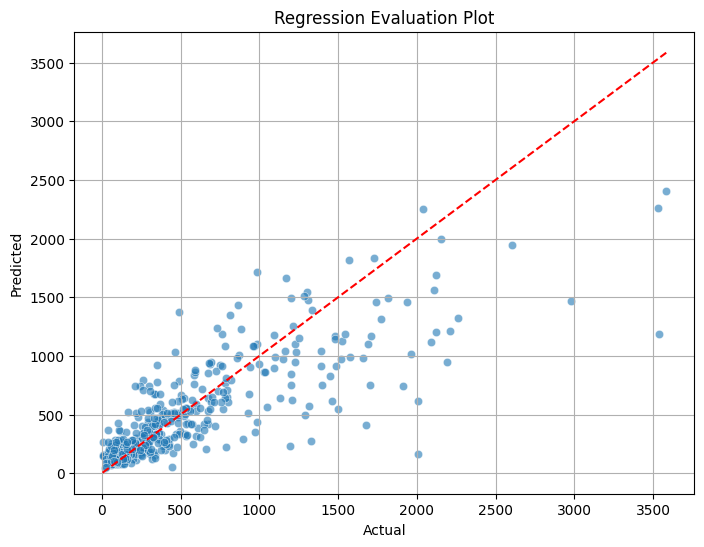

In [84]:
plot_regression_results(y_test, y_pred_test)

This did not significantly affect accuracy but sped up computation.


Examining which features have the greatest impact on predictions.


 98%|===================| 1954/1994 [00:15<00:00]       /tmp/ipython-input-1653821574.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_new)


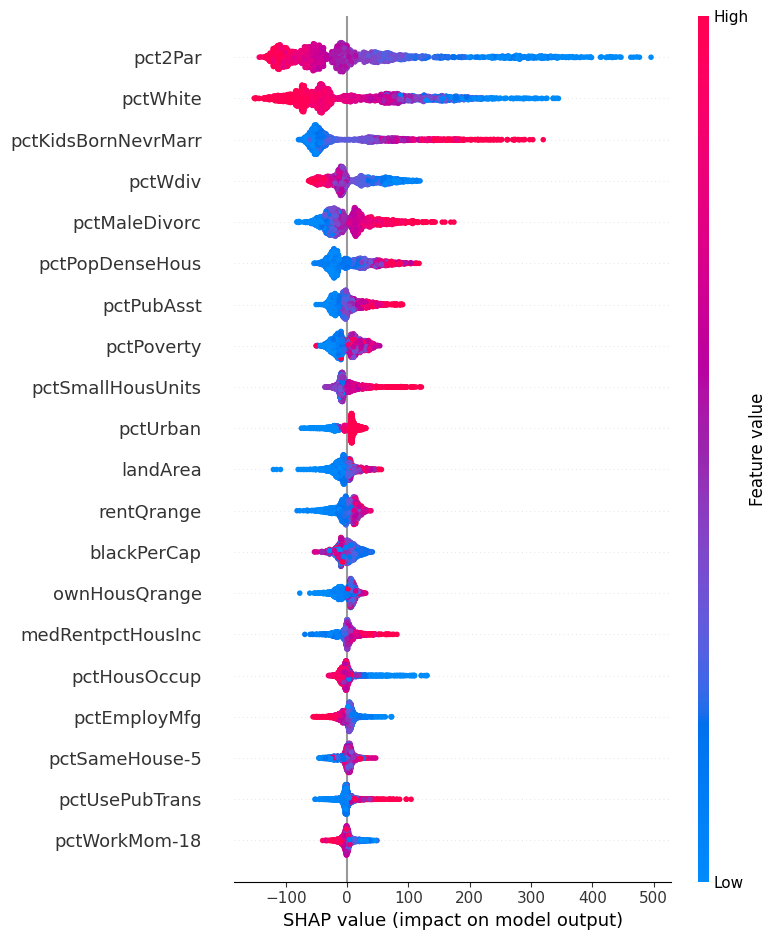

In [85]:
X_new = pd.concat([X_test, X_train])
explainer = shap.Explainer(best_model, X_new)

shap_values = explainer(X_new)

shap.summary_plot(shap_values, X_new)

The SHAP analysis results for XGBRegressor are quite similar to those for RandomForestRegressor, although the model here revealed even more complex relationships within the socio-demographic data.


Trying to transform the target variable.


In [86]:
xgb_reg = XGBRegressor(
    random_state=rnd_state,
    objective='reg:absoluteerror',
    n_estimators=n_steps,
    missing=-999,
    seed= 100,
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.65,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    reg_lambda=0.01,
    learning_rate=0.04,
    )

y_train_log = np.log1p(y_train)
xgb_search.fit(X_train, y_train_log)

y_pred_test_log = xgb_search.predict(X_test)
y_pred_test = np.expm1(y_pred_test_log)

y_pred_train_log = xgb_search.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)

model_scoring(y_train, y_test, y_pred_train, y_pred_test)

Regression metrics:
      MAE score: train - 121.6252, test - 207.7454
      R2 score: train - 0.8315, test - 0.6673
      MSE score:  train - 64616.3169, test - 117954.6177
      RMSE score: train - 254.1974, test - 343.4452


This also did not significantly affect the result but increased overfitting.



Conclusions:

After performing EDA, features with high correlation were removed, and a large number of missing values and outliers were detected, which could potentially be important for further processing.

Based on this information, XGBRegressor and RandomForestRegressor models were selected, as they handle missing values, anomalies, and nonlinear relationships well.

After tuning the best hyperparameters without causing overfitting on the initial dataset, several missing value imputation methods were tested (KNNImputer, IterativeImputer), but they did not lead to noticeable improvements.

It was later decided to remove all features with missing values and add a single flag, since all these missing values occurred in the same features. This slightly improved the model, so further work was conducted with this dataset.

The next step was to select the most informative features. Selection was performed using Spearman correlation coefficients and feature importance from the trained models. Although results improved only slightly, model training time was significantly reduced.

The training results of the models were very similar. Examples of the best results:

**XGBRegressor (28 features instead of 124):**

MAE score: train – 162.9683, test – 213.3754

R² score: train – 0.7453, test – 0.6439

MSE score: train – 97640.5713, test – 126235.5340

RMSE score: train – 312.4749, test – 355.2964

Reducing the number of features did not lead to a loss of accuracy and helped speed up the model.

**RandomForestRegressor (21 features):**

MAE score: train – 223.9451, test – 235.2595

R² score: train – 0.6867, test – 0.6204

MSE score: train – 120114.5413, test – 134570.1337

RMSE score: train – 346.5754, test – 366.8380

The results were very similar, although this model is less prone to overfitting.

The study demonstrated that it is possible to build an effective model even with a large number of missing values, features, and anomalies, provided there is thorough data analysis, reasonable feature selection, and the use of models resistant to noise. Further improvement could be achieved by creating new features, applying ensemble methods, or training separate models for outliers. This leaves plenty of room for future enhancements.